    1- test function
    2- Setup function for mc tests
    3- MC tests

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import numpy as np

# to delete this cell
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format='retina'
import os
import sys
sys.path.insert(0, os.path.abspath('../src/'))

import warnings
warnings.filterwarnings('ignore')

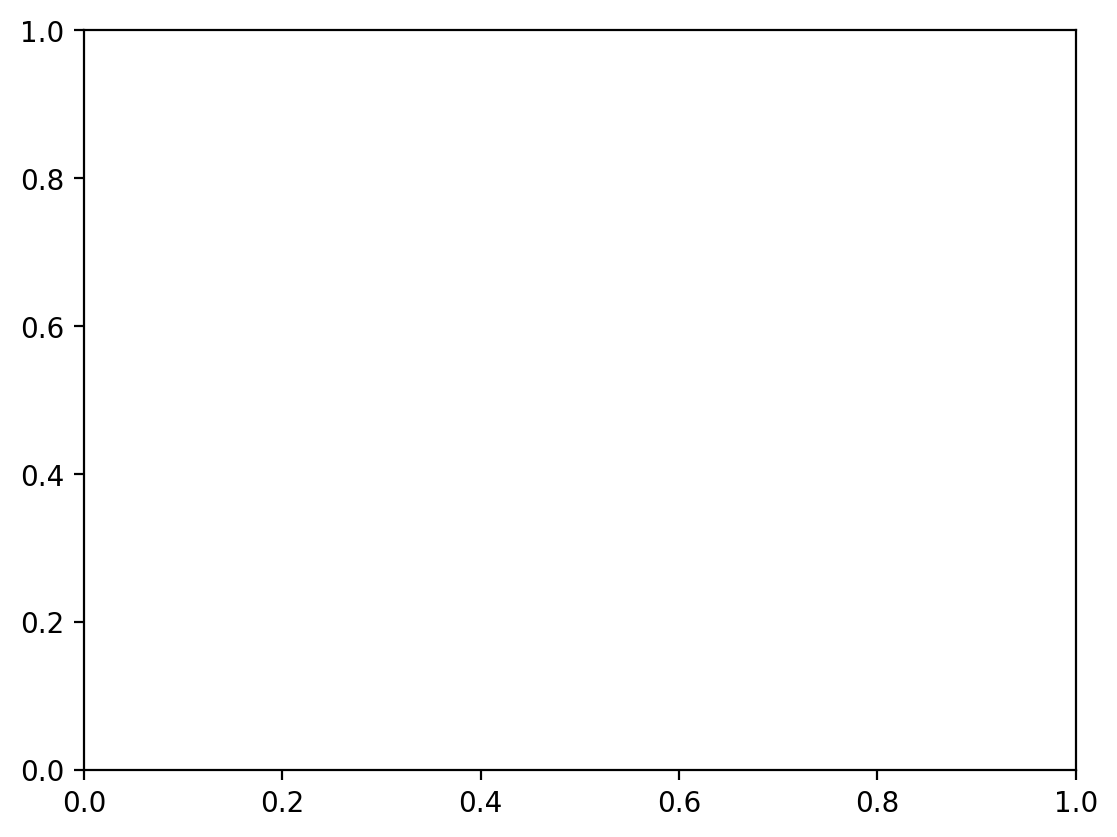

In [2]:
# make plots look nice
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
plt.rc('axes', labelsize=10)
plt.rc('legend', fontsize=10)
mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

# 1- test function

In [3]:
from structure_factor.spatial_windows import BallWindow, BoxWindow, UnitBallWindow
import math

In [4]:
def indicator(x, window):
    return window.indicator_function(x)*1

# Support of all integrands
def support_integrands(d):
    return BoxWindow([[-1/2,1/2]]*d)

In [5]:
def f_1(x):
    d = x.shape[1]
    support = support_integrands(d)
    return (1/np.prod(x+1, axis=1)-1)*indicator(x, support)

def exact_integral_f_1(d):
    return math.log(3)**d - 1

def test_f_1():
    x = np.array([[0, 0, 0, 0], [1/2, 0, -1/2,-1/2], [1, 0, 0, 0]])
    expected = np.array([[0, 5/3, 0]])
    if np.isclose(f_1(x), expected, atol=1e-9).all():
        print("test succeeded")
    else:
        print("test failed, error=", f_1(x) - expected)
test_f_1()   

#control variate setup for f_1
def cv_setup_f_1(d):
    support = support_integrands(d)
    proposal = lambda x: np.prod(x+1, axis=1)*indicator(x, support) #g(x)
    mean_proposal = 1 #mean(g(x))
    c = (math.log(3)**d)/((25/12)**d-1) #-Cov(g(x), f(x))/var(g(x))
    return c, proposal, mean_proposal

test succeeded


In [6]:
# indicator function
def f_2(x):
    d = x.shape[1]
    #radius of the biggest BallWindow included in support_integrands
    r= min(np.diff(support_integrands(d).bounds, axis=1))/2 
    support = BallWindow(center=[0]*d, radius=r) 
    return indicator(x, support)
def exact_integral_f_2(d):
    r= min(np.diff(support_integrands(d).bounds, axis=1))/2 
    return BallWindow(center=[0]*d, radius=r).volume

def test_f_2():
    x = np.array([[1, 2, 2], [1/2, 0, 0], [1/2, 1/2, 1/2]])
    if (f_2(x)== np.array([[0, 1, 0]])).all():
        print("test succeeded")
    else:
        print("test failed, f_2(x)=", f_2(x))
test_f_2()

test succeeded


In [7]:
def f_3(x):
    d = x.shape[1]
    support = support_integrands(d)
    a = 2*np.sin(np.pi*x)**2*np.cos(np.pi*x)
    b = np.cos(np.pi*x - np.pi/4)
    return np.product(a-b, axis=1)*indicator(x, support)

def exact_integral_f_3(d):
    return ((4/3 - np.sqrt(2))/np.pi)**d

def test_f_3():
    x = np.array([[2.2, 3.5, 2], [1/2, 0, 0], [1/4, 0, 0]])
    expected = np.array([[0, -(math.sqrt(2)/2)**3, math.sqrt(2)/4 -1/2]])
    if np.isclose(f_3(x), expected, atol=1e-9).all():
        print("test succeeded")
    else:
        print("test failed, f_3(x)=", f_3(x), "expected=", expected)
test_f_3()

test succeeded


In [8]:
def f_4(x):
    d = x.shape[1]
    r= min(np.diff(support_integrands(d).bounds, axis=1))/2 
    support = BallWindow(center=[0]*d, radius=r)
    norm_x = np.linalg.norm(x, axis=1)
    return np.exp(-norm_x**d)*indicator(x, support)
def exact_integral_f_4(d):
    l=1
    r=math.sqrt(d*(l/2)**d)
    kappa_d = UnitBallWindow(center=[0]*d).volume
    return kappa_d*(1 - np.exp(-r**(d)))/d

def test_f_4():
    x = np.array([[1/2, 1/2, 1/2], [0, 0, 0], [1/4, 1/3, 0]])
    expected = np.array([0, 1, math.exp(- math.sqrt(1/16 + 1/9)**3)])
    if np.isclose(f_4(x), expected, atol=1e-9).all():
        print("test succeeded")
    else:
        print("test failed, f_4(x)=", f_4(x), "expected=", expected)
test_f_4()

test succeeded


In [9]:
def f_5(x):
    N, d = x.shape
    results = np.zeros((N,))
    support = support_integrands(d)
    for n in range(N):
        results[n] = 1 if x[n,0]<np.min(x[n,1:]) else 0
    return results*indicator(x, support)
def exact_integral_f_5(d):
    return 1/d

def test_f_5():
    x = np.array([[1, 1/2, 1/2], [0, 0, 0], 
                  [1/4, 1/3, 1/2], [1/4, 1/3, 1]])
    expected = np.array([0, 0, 1, 0])
    if np.isclose(f_5(x), expected, atol=1e-9).all():
        print("test succeeded")
    else:
        print("test failed, f_5(x)=", f_5(x), "expected=", expected)
test_f_5()

test succeeded


In [112]:
def jaccobi_measure(x, jac_params):
    d = x.shape[1]
    support_window = BoxWindow([[-1,1]]*d)
    alpha, betta = jac_params[0, :], jac_params[1, :]
    a = np.zeros_like(x)
    for i in range(d):
        a[:,i]= (1-x[:,i])**alpha[i]*(1+x[:,i])**betta[i]
    result = np.prod(a, axis=1)
    return result*indicator(x, support_window)

def test_jaccobi_measure():
    x = np.array([[1, 1/2, 0], [1/2, 0, 0], [0, 1.1, 0]])
    #x= np.array([ [1/2, 0, 0]])
    jac_params = np.array([[1, 1, 0], [2, 0, 1]])
    expected = np.array([0, 9/8, 0])
    if np.isclose(jaccobi_measure(x, jac_params), expected, atol=1e-9).all():
        print("test succeeded")
    else:
        print("test failed, error=", jaccobi_measure(x,jac_params)- expected)
test_jaccobi_measure()

test succeeded


In [10]:
def bump_function(points, n=10, R=1/2):
    norm_points = np.linalg.norm(points, axis=1)
    f = np.zeros((points.shape[(N,)]))
    f[norm_points<R]= np.exp(-1/(n*(1- (norm_points[norm_points<R]/R)**2)))
    return f

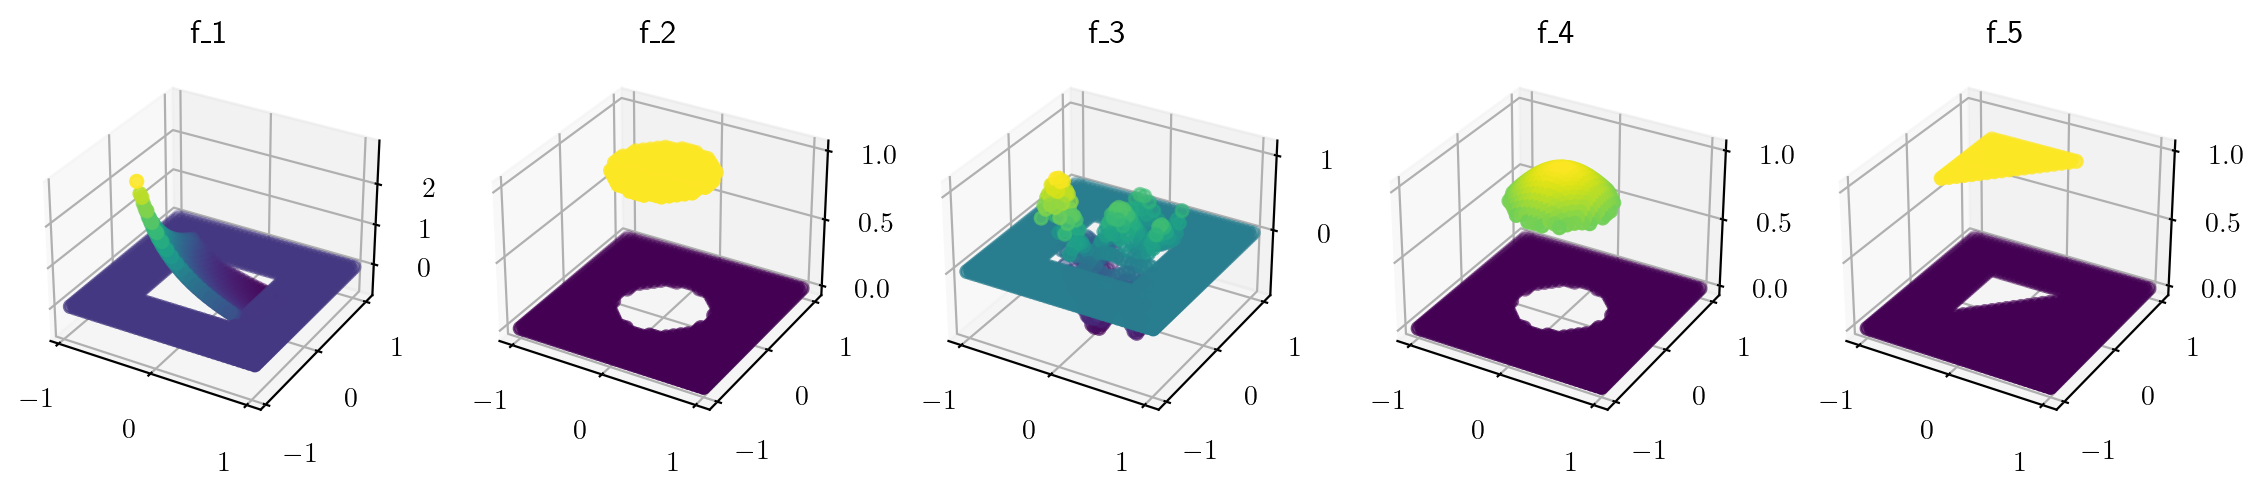

In [11]:
r=1 #radius observation window
x = np.linspace(-r,r, 40)
X, Y = np.meshgrid(x, x)
points = np.array([X.ravel(), Y.ravel()]).T
z_f_1 = f_1(points)
z_f_2 = f_2(points)
z_f_3 = f_3(points)
z_f_4 = f_4(points)
z_f_5 = f_5(points)
fig = plt.figure(figsize=(14, 4))
ax = fig.add_subplot(1, 5, 1, projection='3d')
ax.scatter3D(X.ravel(), Y.ravel(), z_f_1, c=z_f_1)
ax.set_title("f_1")
ax = fig.add_subplot(1, 5, 2, projection='3d')
ax.scatter3D(X.ravel(), Y.ravel(), z_f_2, c=z_f_2)
ax.set_title("f_2")
ax = fig.add_subplot(1, 5, 3, projection='3d')
ax.scatter3D(X.ravel(), Y.ravel(), z_f_3, c=z_f_3)
ax.set_title("f_3")
ax = fig.add_subplot(1, 5, 4, projection='3d')
ax.scatter3D(X.ravel(), Y.ravel(), z_f_4, c=z_f_4)
ax.set_title("f_4")
ax = fig.add_subplot(1, 5, 5, projection='3d')
ax.scatter3D(X.ravel(), Y.ravel(), z_f_5, c=z_f_5)
ax.set_title("f_5")
plt.show()

# 2- Setup functions for MC tests

In [21]:
from structure_factor.point_processes import HomogeneousPoissonPointProcess
from GPPY.gravity_point_process import GravityPointProcess
from dppy.multivariate_jacobi_ope import MultivariateJacobiOPE
from GPPY.numerical_integration import monte_carlo_integration, sobol_sequence, control_variate_integration
import statistics as stat
import copy
import multiprocessing as mp

In [29]:
def samples_push(d, sup_window, nb_point, nb_sample, multiprocess=True, plot_fig=False):
    l = min(np.diff(sup_window.bounds, axis=1)) #length side window 
    r=np.sqrt(d*(l/2)**2) + 0.1 #radius ball window containing support_window
    simu_window = BallWindow(center=[0]*d, radius=r) #simulation window
    simu_nb_point = int(nb_point/sup_window.volume*simu_window.volume) #simulation nb points
    binomial_pp_big = [PointPattern(points=simu_window.rand(n=simu_nb_point), 
                                    window=simu_window) 
                       for _ in range(nb_sample)]
    
    gpp_pp = [GravityPointProcess(p) for p in binomial_pp_big]
    epsilon_0 = gpp_pp[0].epsilon_critical
    print("N Big=", binomial_pp_big[0].points.shape[0], "Nbig=", simu_nb_point,
          ", N expected =", nb_point, ", Epsilon=", epsilon_0)
    time_start = time.time() 
    if __name__ == "__main__":
        push_pp_big = [g.pushed_point_pattern(epsilon=epsilon_0,
                                              multiprocess=multiprocess)
                       for g in gpp_pp]
    push_pp = [g.restrict_to_window(sup_window) for g in push_pp_big]
    time_end = time.time() - time_start
    print("Time Push=", int(time_end/60), "min", time_end%60, "s")
    #plot 
    if plot_fig:
        w_obs = BoxWindow([[-1/2, 1/2]]*2)
        fig, axis = plt.subplots(1, 4, figsize=(14, 3))
        push_pp_big[0].plot(window=simu_window, axis= axis[0], c="g", s=0.2)
        push_pp[0].plot(window=sup_window, axis= axis[0], c="k", s=0.2)
        push_pp[0].plot(window=sup_window, axis= axis[1], c="k", s=0.2)
        w_obs.plot(axis=axis[0])
        axis[1].set_title("Push simu and restricted")
        axis[1].set_title("Push")
        #binomial_pp_big[0].plot(window=window_simulation, axis= axis[2], c="b", s=0.2)
        binomial_pp_big[0].plot(window=sup_window, axis= axis[2], c="k", s=0.2)
        binomial_pp_big[0].plot(window=sup_window, axis= axis[3], c="k", s=0.2)
        push_pp[0].plot(window=sup_window, axis= axis[3], c="g", s=0.2)
        axis[2].set_title("Binomial")
        axis[3].set_title("Binomial and Push")
        plt.show()
    return push_pp

In [22]:
def error(approx, exact):
    return np.array(approx) - exact

def mse(mean, std, exact):
    var = np.square(std)
    bias_square = np.square(error(mean, exact))
    return var + bias_square

def abs_error(approx, exact):
    return np.atleast_2d(np.abs(error(approx, exact)))

In [23]:
from sklearn.linear_model import LinearRegression

def regression_line(x, y, log=True):
    if log:
        x = np.log([x]).T
        y = np.log([y]).T
    else:
        x = np.array(x).T
        y = np.array(y).T
    std_reg = LinearRegression().fit(x, y)
    return x*std_reg.coef_ + std_reg.intercept_

In [38]:

def mc_f_dict(type_mc):
    d = {}
    d["m_"+type_mc]=[]
    d["std_"+type_mc]=[]
    return d

def mc_n_samples( pp_list, type_mc, mc_f_n=None, nb_function=5, weights=None):
    d= pp_list[0].window.dimension
    print("For", type_mc)
    print("---------------")
    if mc_f_n is None:
        mc_f_n = {}
        for i in range(1,nb_function+1):
            mc_f_n["mc_results_f_{}".format(i)] = mc_f_dict(type_mc=type_mc)
    for i in range(1,nb_function+1):
        f = globals()["f_{}".format(i)]
        integ_f = globals()["exact_integral_f_{}".format(i)](d)
        if type_mc=="mccv":
            c, proposal, m_proposal = globals()["cv_setup_f_{}".format(i)](d)
            mc_values=[control_variate_integration(points=p.points, f=f, c=c, proposal=proposal, 
                                                 mean_proposal= m_proposal)
                      for p in pp_list]
        if type_mc=="mcdpp":
            mc_values = [monte_carlo_integration(points=p.points, f=f, weights=w) 
                         for (p,w) in zip(pp_list, weights)]
        else:
            mc_values = [monte_carlo_integration(points=p.points, f=f) for p in pp_list]
        #print(mc_f_n["mc_results_f_{}".format(i)].keys(), type_mc)
        mc_f_n["mc_results_f_{}".format(i)]["m_"+ type_mc].append(stat.mean(mc_values))
        mc_f_n["mc_results_f_{}".format(i)]["std_"+ type_mc].append(stat.stdev(mc_values))            
        print("FOR f%s"%i)
        m_list = mc_f_n["mc_results_f_{}".format(i)]["m_"+ type_mc]
        std_list = mc_f_n["mc_results_f_{}".format(i)]["std_"+ type_mc]
        print("error=", error(m_list, integ_f), ", std=", std_list,)
        print("MSE=", mse(m_list, std_list, integ_f))
    return mc_f_n

In [113]:
from structure_factor.point_pattern import PointPattern

def mc_results(d, nb_point_list, nb_sample, nb_function=5):
    print("d=", d, ", nb points simu=", nb_point_list, ", nb samples=", nb_sample)
    print("------------------------------------------------")
    sup_window = support_integrands(d) #support window
    N_output_list=[]
    time_1 = time.time()
    mcp, mc, rqmc, mccv, mcdpp =None, None, None, None, None
    for n in nb_point_list :
        # Push pp
        push_pp = samples_push(d, sup_window=sup_window, nb_point=n, nb_sample=nb_sample)
        nb_point_output= int(stat.mean([p.points.shape[0] for p in push_pp]))
        print("N expected=", n, ", N obtained", nb_point_output)
        N_output_list.append(nb_point_output)
        # Binomial pp
        binomial_pp = [PointPattern(points=sup_window.rand(n=nb_point_output), window=sup_window) 
                           for _ in range(nb_sample)]
        # DPPY
        time_start = time.time()
        jac_params = -0.5 + np.random.rand(d, 2)
        dpp = MultivariateJacobiOPE(nb_point_output, jac_params)
        dpp_points = [dpp.sample()/2 for _ in range(nb_sample)]
        dpp_pp = [PointPattern(p, window=sup_window) for p in dpp_points]
        weights_dpp = [1/(dpp.K(p, eval_pointwise=True)*jaccobi_measure(p, jac_params)) 
                       for p in dpp_points]
        time_end = time.time() - time_start
        print("Time DPPY=", int(time_end/60), "min", time_end%60, "s")
        
        # RQMC
        time_start = time.time()
        sobol_points_list = [sobol_sequence(window=sup_window, nb_points=nb_point_output) 
                             for _ in range(nb_sample)]
        sobol_pp = [PointPattern(p, window=sup_window) for p in sobol_points_list]
        time_end = time.time() - time_start
        print("Time RQMC=", int(time_end/60), "min", time_end%60, "s")
        # MC
        ## MC classic
        mc = mc_n_samples(pp_list=binomial_pp, type_mc="mc", mc_f_n=mc, nb_function=nb_function)
        ## MCP
        mcp = mc_n_samples(pp_list=push_pp, type_mc="mcp", mc_f_n=mcp, nb_function=nb_function)
        ## MCDPP
        mcdpp = mc_n_samples(pp_list=dpp_pp, type_mc="mcdpp", mc_f_n=mcdpp, nb_function=nb_function, 
                           weights=weights_dpp)
        ## RQMC 
        rqmc = mc_n_samples(pp_list=sobol_pp, type_mc="rqmc", mc_f_n=rqmc, nb_function=nb_function)
        #MC Control variate
        time_start = time.time()
        mccv = mc_n_samples(pp_list=binomial_pp, type_mc="mccv", mc_f_n=mccv, nb_function=1)
        time_end = time.time() - time_start
        print("Time MCCV=", int(time_end/60), "min", time_end%60, "s")
        print("----------------------------------------------")
        print("----------------------------------------------")
    time_2 = time.time() - time_1
    print("Time all", int(time_2/60), "min", time_2%60, "s")
    results = {"mc": mc, "mcp": mcp, "mcdpp": mcdpp, "rqmc": rqmc, "mccv": mccv}
    return results, N_output_list


In [119]:
import colorsys

def plot_mc_results(d, mc_list, nb_point_list, nb_sample, save_fig=False):
    log_nb_pts = np.log([nb_point_list]).T
    nb_function = len(mc_list["mc"])
    type_mc = mc_list.keys()
    x = np.linspace(-1,1, 40)
    X, Y = np.meshgrid(x, x)
    points = np.array([X.ravel(), Y.ravel()]).T
    #col = [colorsys.hsv_to_rgb(x*1.0/len(type_mc), 0, 1) for x in range(len(type_mc))]
    col = ["b", "k", "g", "m", "grey", "y"]
    for j in range(1, nb_function+1) :
        z_f = globals()["f_{}".format(j)](points)
        fig= plt.figure(figsize=(10,11))
        #plot
        ax = fig.add_subplot(nb_function, 3, 1+ 3*(j-1), projection='3d')
        ax.scatter3D(X.ravel(), Y.ravel(), z_f, c=z_f)
        ax.set_title(r"$f_%s$"%j)
        #std
        ax = fig.add_subplot(nb_function, 3, 2+ 3*(j-1))
        i=0
        for t in type_mc:
            if t!="mccv" or j==1:
                std_f = mc_list[t]["mc_results_f_{}".format(j)]["std_"+ t]
                ax.scatter(log_nb_pts, np.log(std_f), c=col[i],s=1, label=t)
                ax.plot(log_nb_pts, regression_line(nb_point_list, std_f), c=col[i])
                i=i+1
        ax.set_title("std (d=%s)" %d)
        ax.set_xlabel(r"$\log(N)$")
        ax.set_ylabel(r"$\log(std)$")
        ax.legend()
        #MSE
        ax = fig.add_subplot(nb_function, 3, 3+ 3*(j-1))
        i=0
        for t in type_mc:
            integ_f = globals()["exact_integral_f_{}".format(j)](d)
            if t!="mccv" or j==1:
                m_f = mc_list[t]["mc_results_f_{}".format(j)]["m_"+ t]
                std_f = mc_list[t]["mc_results_f_{}".format(j)]["std_"+ t]
                mse_f = mse(m_f, std_f, integ_f)
                err_bar = np.array(std_f/np.sqrt(nb_sample))  
                ax.plot(nb_point, mse_f, c=col[i], marker=".", label=t)
                ax.errorbar(x=nb_point, y=mse_f, yerr=3 *err_bar,
                             ecolor=col[i], capsize=4, capthick=1)
                i=i+1
        
        ax.set_title("MSE (d=%s)" %d)
        ax.set_xlabel(r"$N$")
        ax.set_ylabel(r"$MSE$")
        ax.legend()
        plt.tight_layout()
        if save_fig :
            plt.savefig("")
    plt.show()

# 3- MC tests 

## d=2

In [120]:
d=2
#N = [2**5, 2**6, 2**7, 2**8, 300, 400,  2**9, 700, 2**(10), 1300, 1500, 2**(11)]
nb_point_list=[2**5, 2**6, 2**7, 2**8, 300, 400,  2**9, 700, 2**(10)]
nb_sample=50
nb_function=5
mc_results_2d, nb_point = mc_results(d, nb_point_list, nb_sample, nb_function)

d= 2 , nb points simu= [32, 64, 128, 256, 300, 400, 512, 700, 1024] , nb samples= 50
------------------------------------------------
N Big= 65 Nbig= 65 , N expected = 32 , Epsilon= 0.0025054667547588826
Time Push= 0 min 0.30454421043395996 s
N expected= 32 , N obtained 31
Time DPPY= 0 min 0.8374300003051758 s
Time RQMC= 0 min 0.012027263641357422 s
For mc
---------------
FOR f1
error= [0.03087941] , std= [0.11005538828640843]
MSE= [0.01306573]
FOR f2
error= [-0.00217236] , std= [0.0782162193890401]
MSE= [0.0061225]
FOR f3
error= [0.02718254] , std= [0.06155976611260762]
MSE= [0.0045285]
FOR f4
error= [0.07235604] , std= [0.06932205057649445]
MSE= [0.01004094]
FOR f5
error= [-0.01096774] , std= [0.08776594180363068]
MSE= [0.00782315]
For mcp
---------------
FOR f1
error= [0.00975896] , std= [0.06033451153498441]
MSE= [0.00373549]
FOR f2
error= [0.00150402] , std= [0.04952175538573238]
MSE= [0.00245467]
FOR f3
error= [-0.00942196] , std= [0.041184666962298104]
MSE= [0.00178495]
FOR f4
e

N Big= 523 Nbig= 523 , N expected = 256 , Epsilon= 0.0003113868815665915
Time Push= 0 min 2.728208303451538 s
N expected= 256 , N obtained 255
Time DPPY= 0 min 21.523133993148804 s
Time RQMC= 0 min 0.011892080307006836 s
For mc
---------------
FOR f1
error= [ 0.03087941  0.01240565 -0.0003961   0.00546394] , std= [0.11005538828640843, 0.07240601490899613, 0.05236232806003475, 0.03366713961774371]
MSE= [0.01306573 0.00539653 0.00274197 0.00116333]
FOR f2
error= [-0.00217236  0.00158596  0.00153097  0.00440576] , std= [0.0782162193890401, 0.05309125649715152, 0.03981462026359792, 0.021711845798404596]
MSE= [0.0061225  0.0028212  0.00158755 0.00049081]
FOR f3
error= [ 0.02718254 -0.00207943 -0.00115737 -0.0010393 ] , std= [0.06155976611260762, 0.053572021938726296, 0.02727661607643572, 0.023066058802391216]
MSE= [0.0045285  0.00287429 0.00074535 0.00053312]
FOR f4
error= [0.07235604 0.07768462 0.07747738 0.07997986] , std= [0.06932205057649445, 0.0484666388494299, 0.034029475705951724, 0.

FOR f5
error= [4.24887817 3.58196991 3.7394328  3.93658883 3.8391136 ] , std= [0.40773204713608263, 0.24369713484481406, 0.14932872972059957, 0.10355139457510983, 0.07549910924501356]
MSE= [18.21921111 12.88989673 14.00565674 15.50745454 14.74449335]
For rqmc
---------------
FOR f1
error= [ 1.16597241e-03  1.52820597e-03 -4.81307632e-04  5.13048602e-04
  3.36804549e-05] , std= [0.017283722151706885, 0.008182180121170975, 0.004627273398650067, 0.0020903047440266114, 0.002031893601994405]
MSE= [3.00086543e-04 6.92834850e-05 2.16433161e-05 4.63259279e-06
 4.12972598e-06]
FOR f2
error= [0.00427926 0.00031612 0.00027113 0.00079792 0.00091056] , std= [0.0443163696964841, 0.02706878999164016, 0.016167481608167455, 0.009966321997954986, 0.010065744325384917]
MSE= [1.98225265e-03 7.32819325e-04 2.61460972e-04 9.99642426e-05
 1.02148331e-04]
FOR f3
error= [ 0.00156849  0.00069103 -0.00050544  0.0002067  -0.00075306] , std= [0.029197577156422787, 0.011024303178713913, 0.0049755051162282665, 0.002

N Big= 1047 Nbig= 1047 , N expected = 512 , Epsilon= 0.00015554473644634897
Time Push= 0 min 6.5583391189575195 s
N expected= 512 , N obtained 512
Time DPPY= 1 min 12.353011131286621 s
Time RQMC= 0 min 0.013170003890991211 s
For mc
---------------
FOR f1
error= [ 0.03087941  0.01240565 -0.0003961   0.00546394 -0.00949147 -0.0081505
  0.00610223] , std= [0.11005538828640843, 0.07240601490899613, 0.05236232806003475, 0.03366713961774371, 0.03172075539054809, 0.02235549605137882, 0.02574033372508756]
MSE= [0.01306573 0.00539653 0.00274197 0.00116333 0.00109629 0.0005662
 0.0006998 ]
FOR f2
error= [-0.00217236  0.00158596  0.00153097  0.00440576 -0.00472702  0.00410184
 -0.00227316] , std= [0.0782162193890401, 0.05309125649715152, 0.03981462026359792, 0.021711845798404596, 0.02521007267822869, 0.019535420473110476, 0.019443200766404937]
MSE= [0.0061225  0.0028212  0.00158755 0.00049081 0.00065789 0.00039846
 0.00038321]
FOR f3
error= [ 0.02718254 -0.00207943 -0.00115737 -0.0010393   0.0025

FOR f3
error= [-9.42195592e-03 -1.27900080e-03 -4.83172074e-04  1.19197253e-03
  5.93297180e-04 -2.50290655e-03  1.74219120e-05  2.95512121e-03] , std= [0.041184666962298104, 0.027374290517112206, 0.02105560263965237, 0.010758633231216655, 0.009708098706242443, 0.008502129620482777, 0.009090192443113152, 0.00811292679316468]
MSE= [1.78495005e-03 7.50987624e-04 4.43571858e-04 1.17168988e-04
 9.45991820e-05 7.85507493e-05 8.26319022e-05 7.45523225e-05]
FOR f4
error= [0.07832951 0.07859282 0.08059263 0.07632806 0.07687342 0.07620579
 0.07549122 0.07482692] , std= [0.04354077363416545, 0.03281269986306051, 0.018843023233791268, 0.014600275723077724, 0.011802247574758399, 0.01213948352039565, 0.008040252491093983, 0.007557699663991083]
MSE= [0.00803131 0.0072535  0.00685023 0.00603914 0.00604882 0.00595469
 0.00576357 0.00565619]
FOR f5
error= [ 0.00606811  0.00753999  0.00054784  0.00408308  0.00187603  0.00289216
 -0.00300527 -0.00032557] , std= [0.05278175794202542, 0.04237012753052795, 

FOR f1
error= [1.02896143 2.8468637  1.93539532 3.53408033 2.03485813 4.42329669
 0.74964268 1.10449485 2.30150061] , std= [0.3306327475309865, 0.1826497235803386, 0.11000654797598576, 0.0833614716040802, 0.0673958396384299, 0.09014888776973526, 0.028574627496502265, 0.025973079387514142, 0.023408669372527433]
MSE= [ 1.16807964  8.13799384  3.75785647 12.49667294  4.1451898  19.57368042
  0.56278066  1.22058348  5.297453  ]
FOR f2
error= [4.22484498 3.8620832  3.82765807 3.80058871 3.80637849 3.89488473
 3.90429785 3.8895386  3.77501551] , std= [0.5348968743757837, 0.32820425964011585, 0.18154151398341362, 0.13176305414448872, 0.11196343617420051, 0.08647351271486597, 0.07869061587314483, 0.06524439348816816, 0.04003145688999192]
MSE= [18.13542979 15.02340471 14.68392359 14.46183608 14.50105304 15.17760471
 15.24973393 15.13276732 14.2523446 ]
FOR f3
error= [0.09276635 0.00891846 0.00280034 0.06722827 0.00196472 0.1544691
 0.07877416 0.04154464 0.00344011] , std= [0.2978700067499478, 0

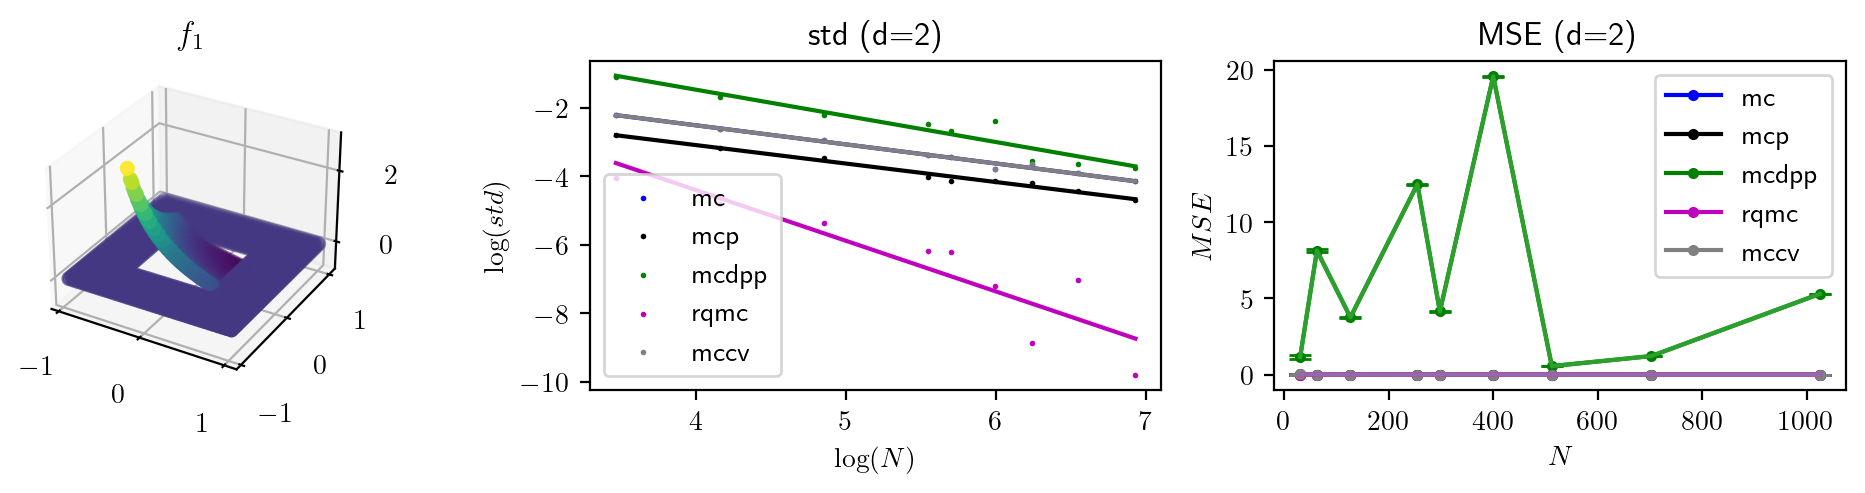

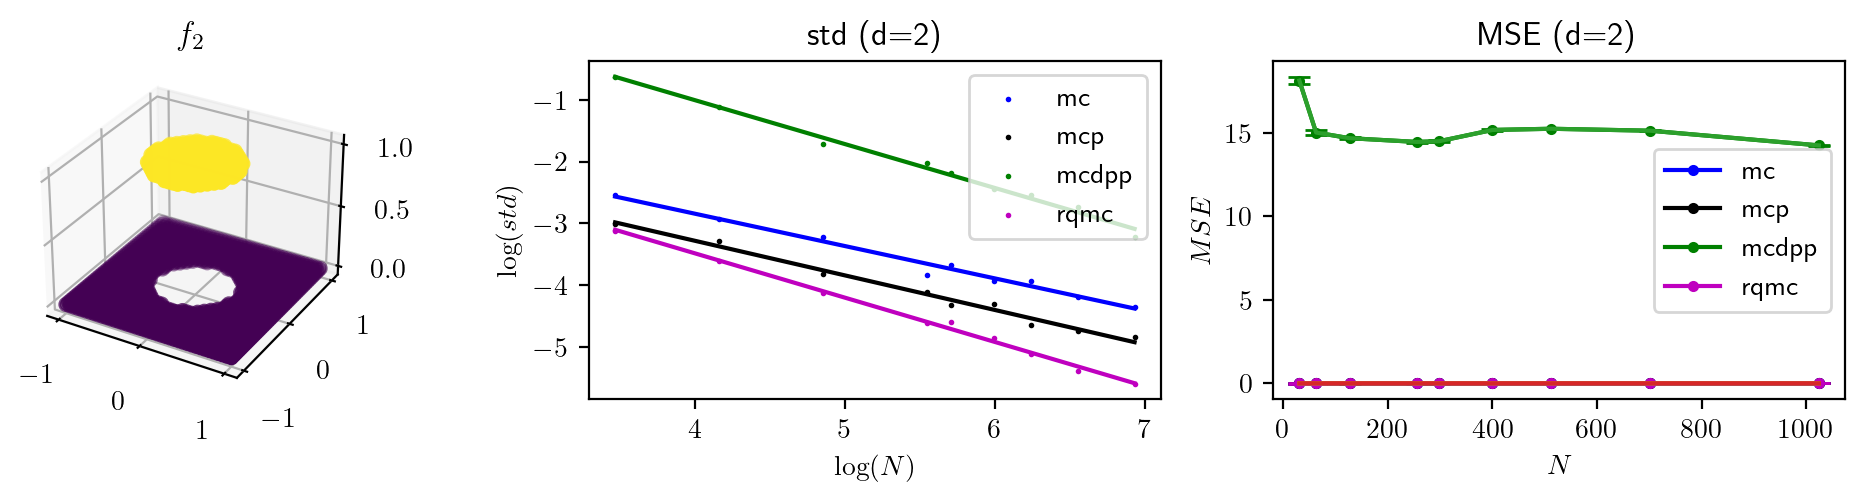

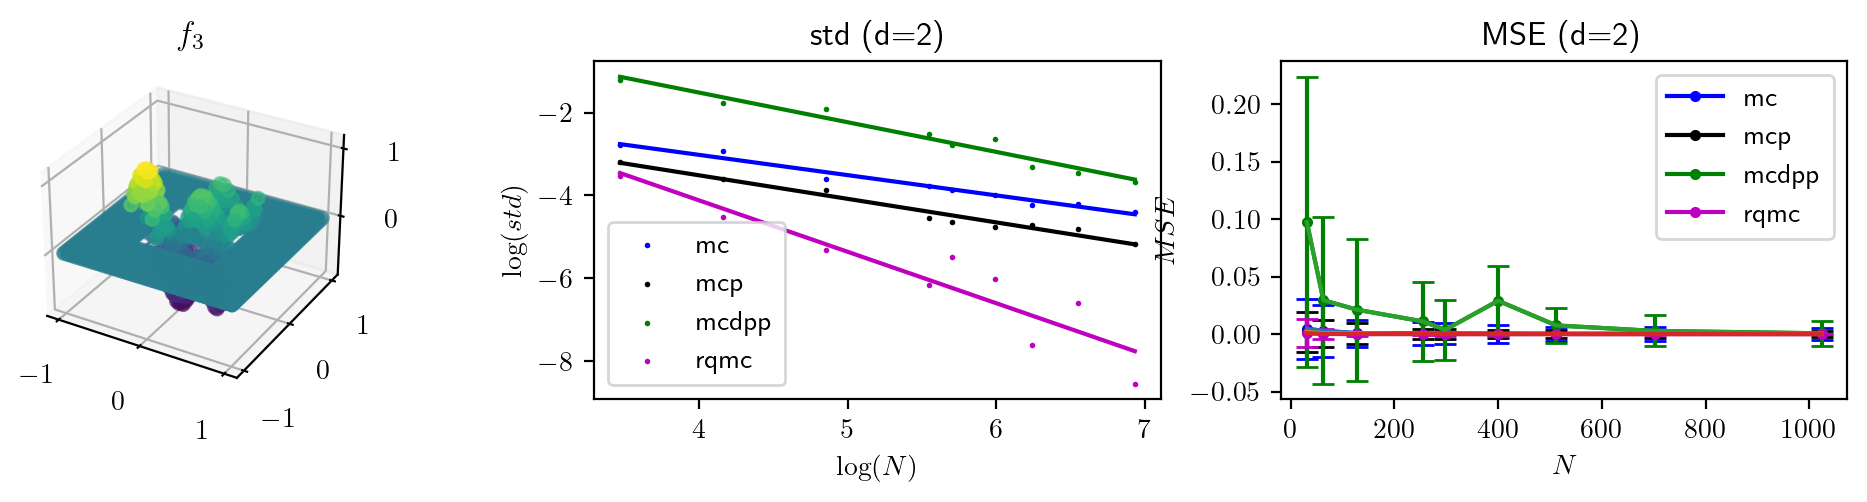

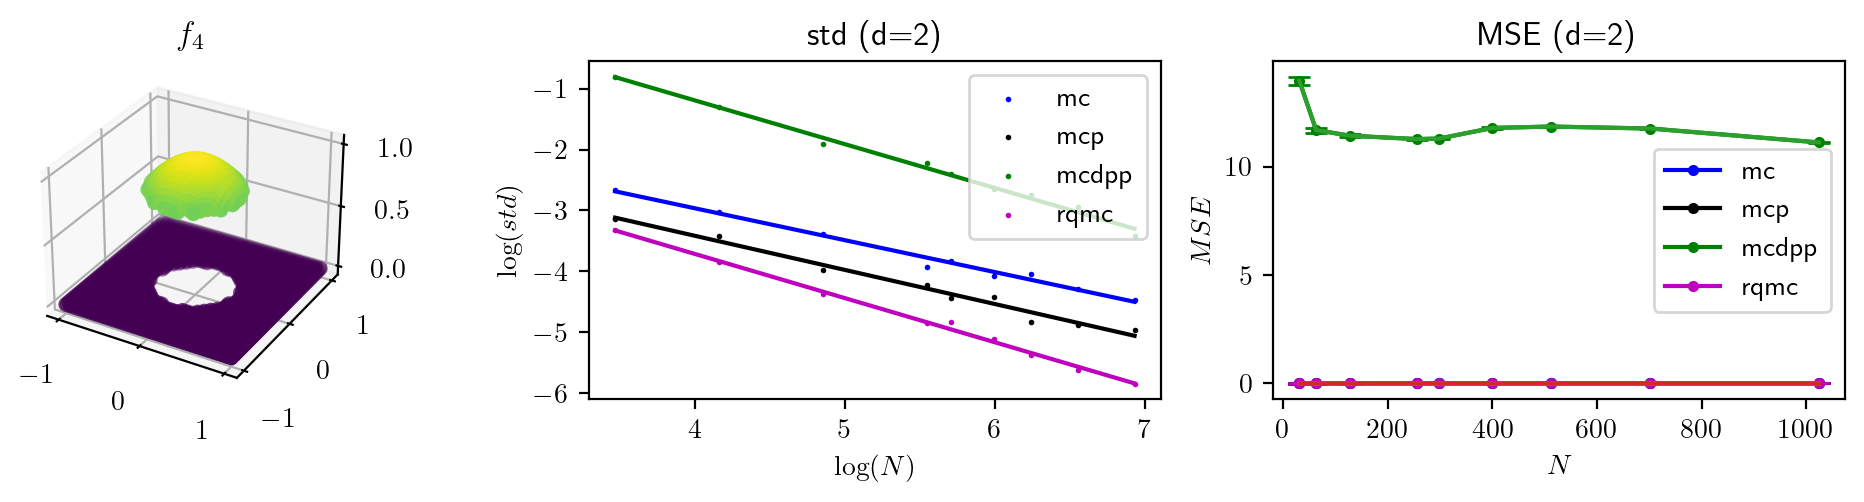

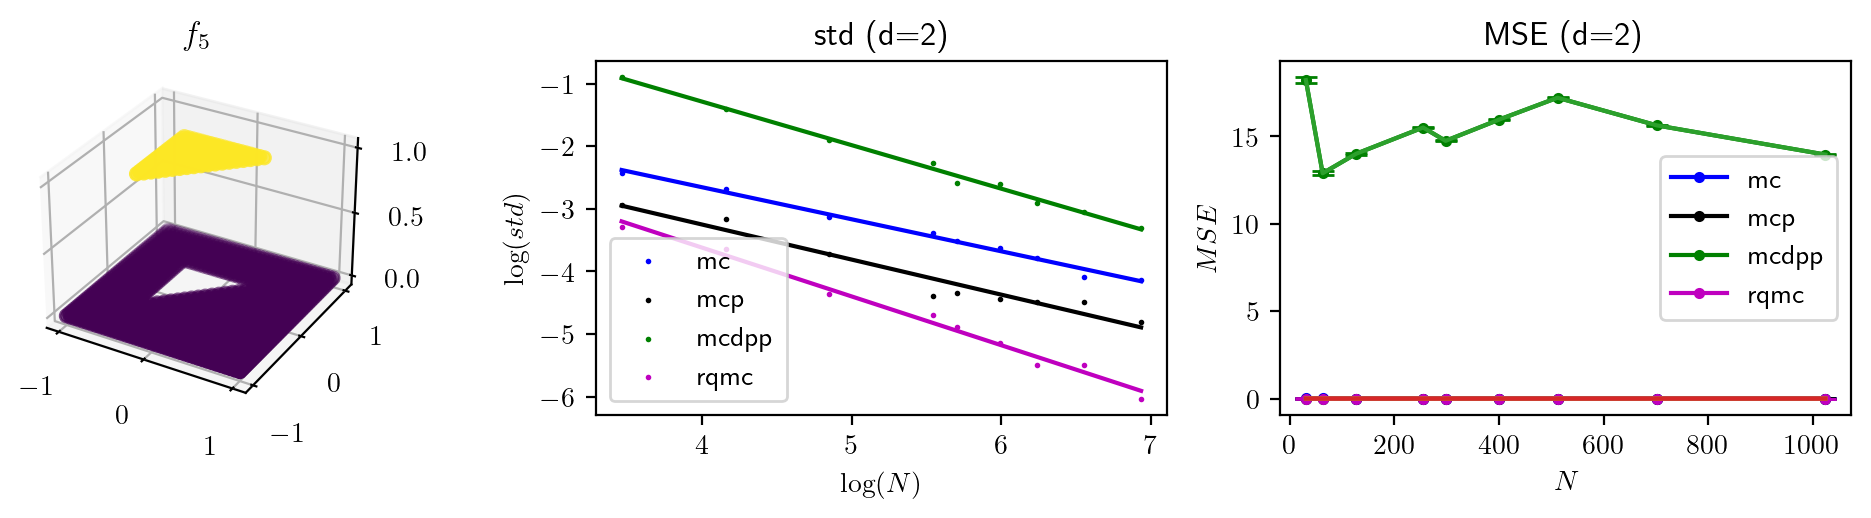

In [121]:
plot_mc_results(d, mc_results_2d, nb_point_list, nb_sample, save_fig=False)

## d=3

In [87]:
d=3
#N = [2**5, 2**6, 2**7, 2**8, 300, 400,  2**9, 700, 2**(10), 1300, 1500, 2**(11)]
nb_point_list=[2**5, 2**6, 2**7, 2**8, 300, 400,  2**9, 700, 2**(10)]
nb_sample=50
nb_function=5
mc_results_3d, nb_point = mc_results(d, nb_point_list, nb_sample, nb_function)

d= 3 , nb points simu= [32, 64, 128, 256, 300, 400, 512, 700, 1024] , nb samples= 50
------------------------------------------------
N Big= 120 Nbig= 120 , N expected = 32 , Epsilon= 0.0012520830763220305
Time Push= 0 min 0.5244901180267334 s
-----------------------------------------------
, N expected= 32 , N obtained 31
Time RQMC= 0 min 0.011996984481811523 s
For mc
---------------
FOR f1
error= [-0.00772312] , std= [0.119318689223785]
MSE= [0.0142966]
FOR f2
error= [-0.00166329] , std= [0.07277313367952505]
MSE= [0.0052987]
FOR f3
error= [0.00384493] , std= [0.04162381231459895]
MSE= [0.00174733]
FOR f4
error= [0.20448485] , std= [0.06894586899466554]
MSE= [0.04656759]
FOR f5
error= [0.00473118] , std= [0.08797861429516478]
MSE= [0.00776262]
For mcp
---------------
FOR f1
error= [0.00935571] , std= [0.1007397659853466]
MSE= [0.01023603]
FOR f2
error= [0.01218127] , std= [0.06956085187771012]
MSE= [0.0049871]
FOR f3
error= [0.00369679] , std= [0.0383884310056223]
MSE= [0.00148734]
F

FOR f5
error= [ 0.00086022 -0.00285714  0.00197917  0.00139108] , std= [0.04360138681111473, 0.0291610329979368, 0.013562908509788672, 0.009757466351465051]
MSE= [1.90182090e-03 8.58529111e-04 1.87869588e-04 9.71432424e-05]
For mccv
---------------
FOR f1
error= [ 0.00015559 -0.00169522  0.00038926  0.00036559] , std= [0.03464925317137515, 0.012493706773419901, 0.002278982016137092, 0.0028867127408109066]
MSE= [1.20059495e-03 1.58966493e-04 5.34528206e-06 8.46676927e-06]
Time MCCV= 0 min 0.007850408554077148 s
----------------------------------------------
----------------------------------------------
N Big= 1132 Nbig= 1132 , N expected = 300 , Epsilon= 0.00013272965473378414
Time Push= 0 min 9.034637212753296 s
-----------------------------------------------
, N expected= 300 , N obtained 299
Time RQMC= 0 min 0.014396905899047852 s
For mc
---------------
FOR f1
error= [-0.00772312 -0.00648384 -0.01515073  0.00334293  0.00594058] , std= [0.119318689223785, 0.08559663094911223, 0.06263

Time Push= 0 min 21.64164710044861 s
-----------------------------------------------
, N expected= 512 , N obtained 510
Time RQMC= 0 min 0.013303041458129883 s
For mc
---------------
FOR f1
error= [-0.00772312 -0.00648384 -0.01515073  0.00334293  0.00594058  0.0006388
 -0.0007662 ] , std= [0.119318689223785, 0.08559663094911223, 0.0626351925557617, 0.04892346077157722, 0.04398975251827633, 0.036016689577358645, 0.040413861139313785]
MSE= [0.0142966  0.00736882 0.00415271 0.00240468 0.00197039 0.00129761
 0.00163387]
FOR f2
error= [-0.00166329 -0.00963052  0.00327622  0.00128311 -0.00058874 -0.0068311
  0.00224436] , std= [0.07277313367952505, 0.07360992689025499, 0.045531337324653975, 0.032731668804451226, 0.03374305628753784, 0.02626183339272216, 0.02105015459109994]
MSE= [0.0052987  0.00551117 0.00208384 0.00107301 0.00113894 0.00073635
 0.00044815]
FOR f3
error= [ 0.00384493 -0.00573736 -0.00153433  0.00351489  0.00161693  0.00149216
 -0.00030957] , std= [0.04162381231459895, 0.0286

FOR f1
error= [ 1.03163418e-04 -1.69375773e-03  3.87778817e-04  3.67394192e-04
 -4.16304463e-04  6.98272236e-04  3.97066227e-05 -1.52027883e-04] , std= [0.03508971821078171, 0.012741511940642441, 0.0022764418872182743, 0.0029064132022075173, 0.0036253154587288536, 0.0024960688139536932, 0.0015293068858908173, 0.0013719314238432416]
MSE= [1.23129897e-03 1.65214942e-04 5.33256008e-06 8.58221619e-06
 1.33162216e-05 6.71794364e-06 2.34035617e-06 1.90530831e-06]
FOR f2
error= [ 0.00736897 -0.00836068  0.00171372 -0.00068539 -0.00052185  0.0021588
 -0.0006576  -0.0007621 ] , std= [0.0665288416542596, 0.037836558299444, 0.021902315307207286, 0.01512695419983061, 0.011184615299302071, 0.011767320656782172, 0.009984334409311839, 0.008234662762350771]
MSE= [4.48038844e-03 1.50150612e-03 4.82648267e-04 2.29294503e-04
 1.25367949e-04 1.43130254e-04 1.00119370e-04 6.83904663e-05]
FOR f3
error= [ 1.39162102e-02  1.58398360e-03 -7.52606223e-04  2.56845908e-04
 -1.56823480e-03  5.76488198e-05  3.69630

FOR f1
error= [ 1.55587338e-04 -1.69522385e-03  3.89259590e-04  3.65593790e-04
 -4.22556104e-04  7.02330592e-04  4.03513312e-05 -1.57950893e-04
 -6.00618321e-06] , std= [0.03464925317137515, 0.012493706773419901, 0.002278982016137092, 0.0028867127408109066, 0.0035928388302945246, 0.0024952799867133013, 0.0015201889363921114, 0.0013661664420232234, 0.0006674434817420933]
MSE= [1.20059495e-03 1.58966493e-04 5.34528206e-06 8.46676927e-06
 1.30870445e-05 6.71969047e-06 2.31260263e-06 1.89135923e-06
 4.45516876e-07]
Time MCCV= 0 min 0.011788129806518555 s
----------------------------------------------
----------------------------------------------
Time all 2 min 42.34353995323181 s


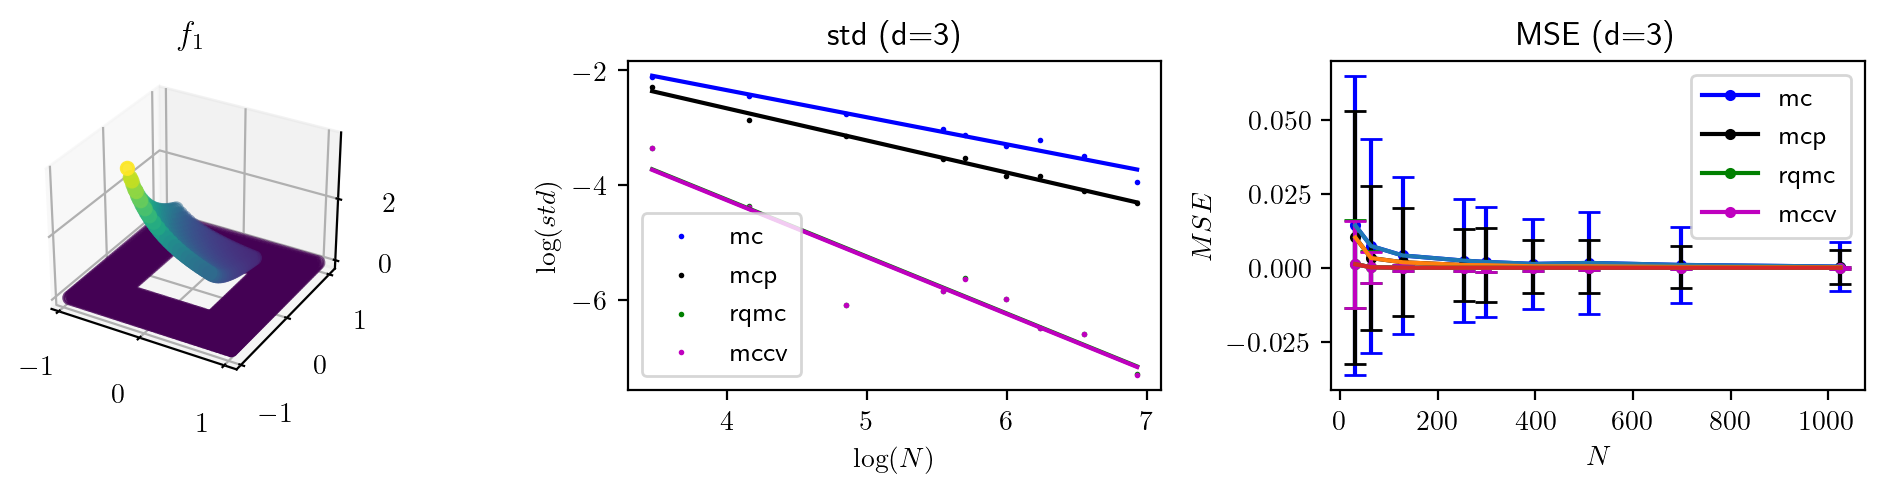

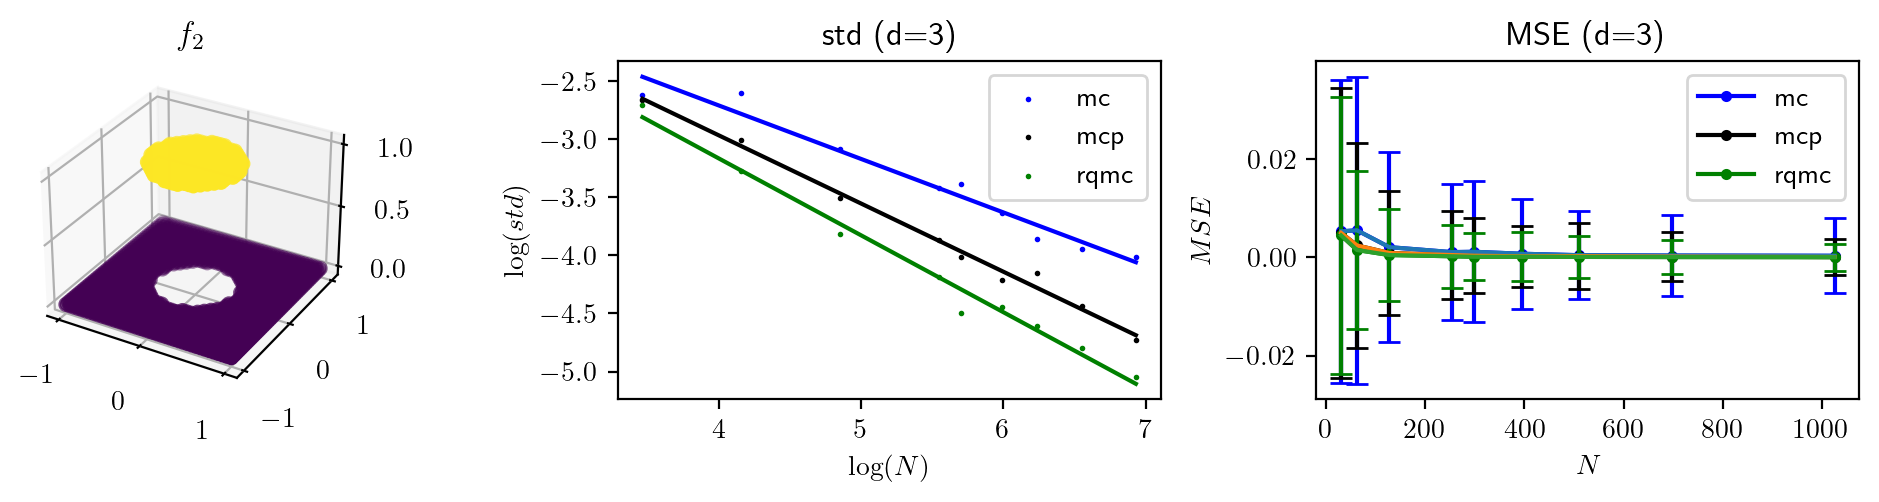

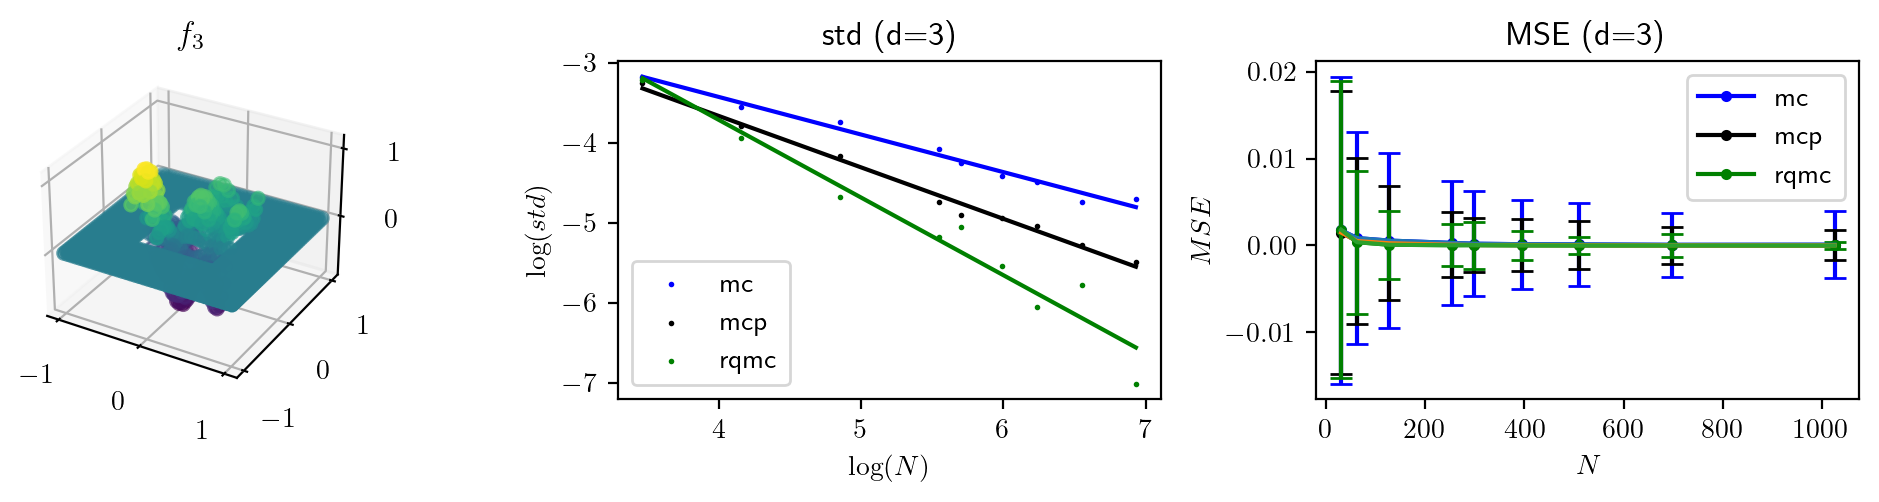

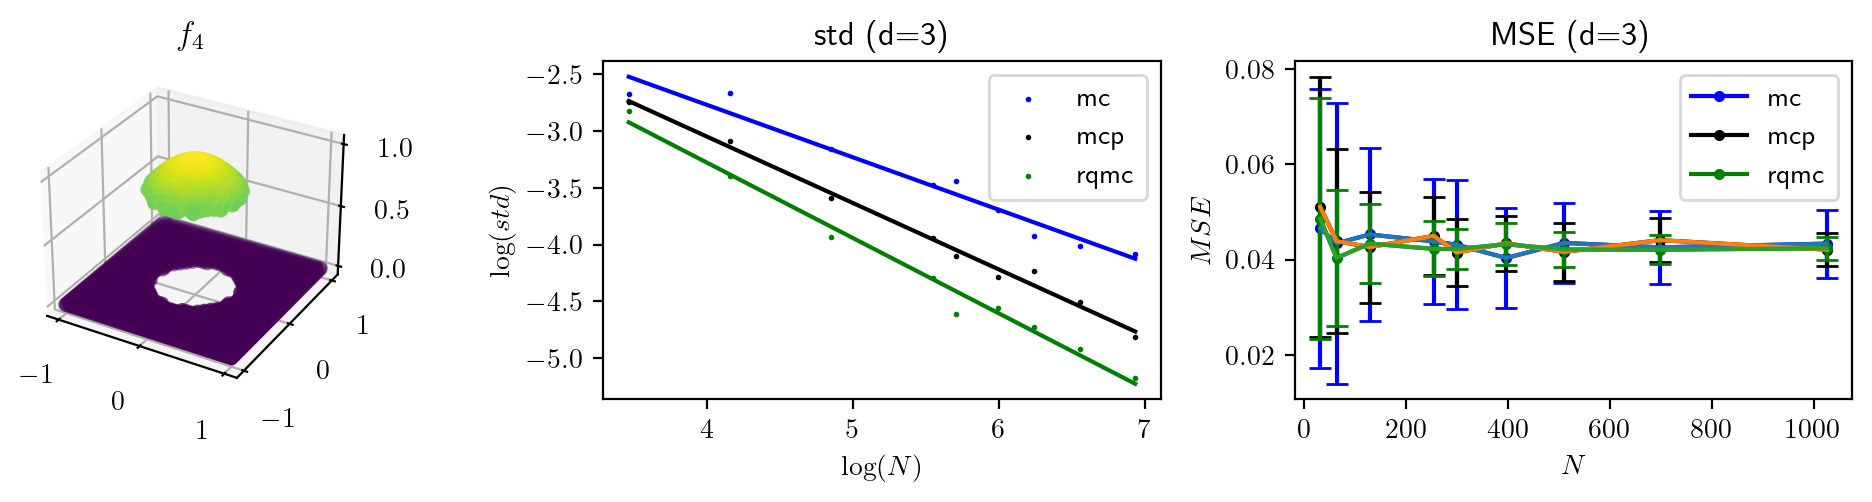

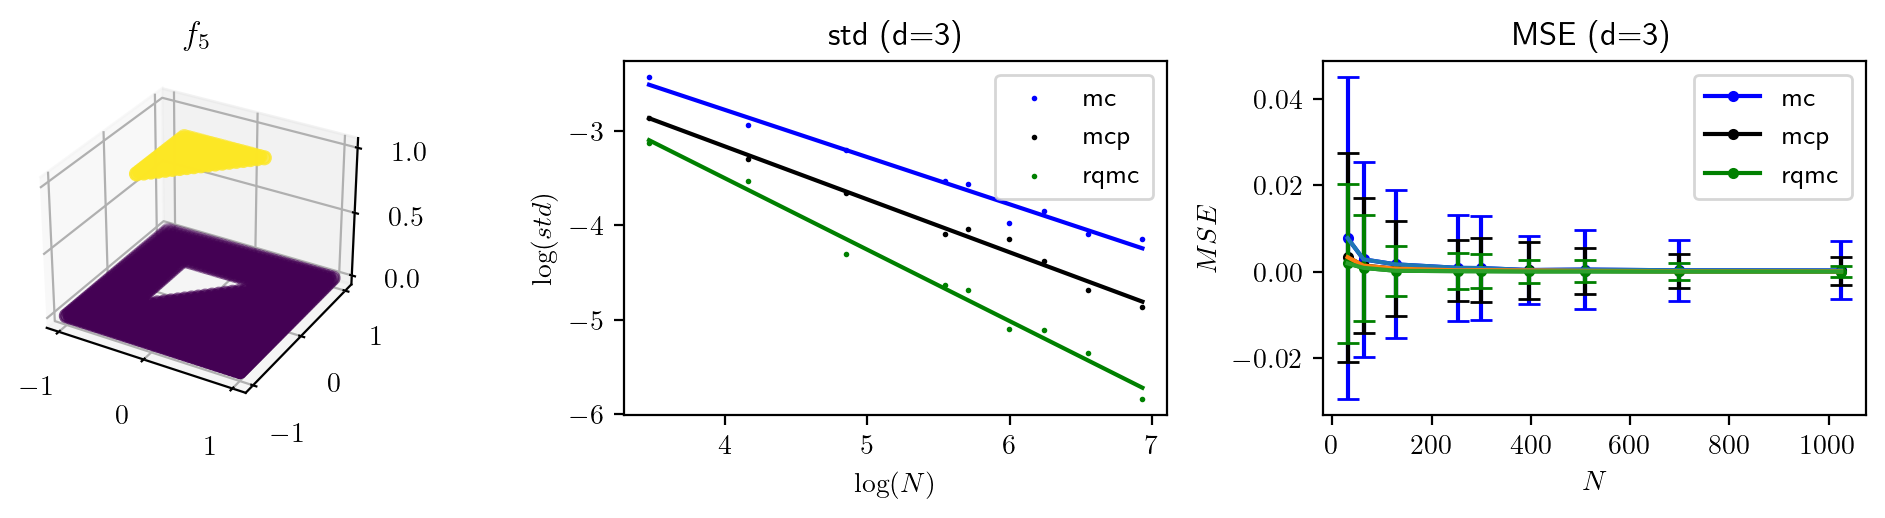

In [88]:
plot_mc_results(d, mc_results_3d, nb_point_list, nb_sample, save_fig=False)

## d= 5

In [89]:
d=5
#N = [2**5, 2**6, 2**7, 2**8, 300, 400,  2**9, 700, 2**(10), 1300, 1500, 2**(11)]
nb_point_list=[2**5, 2**6, 2**7, 2**8, 300, 400,  2**9, 700, 2**(10)]
nb_sample=50
nb_function=5
mc_results_5d, nb_point = mc_results(d, nb_point_list, nb_sample, nb_function)

d= 5 , nb points simu= [32, 64, 128, 256, 300, 400, 512, 700, 1024] , nb samples= 50
------------------------------------------------
N Big= 451 Nbig= 451 , N expected = 32 , Epsilon= 0.0005944570671862138
Time Push= 0 min 2.5774831771850586 s
-----------------------------------------------
, N expected= 32 , N obtained 31
Time RQMC= 0 min 0.020605802536010742 s
For mc
---------------
FOR f1
error= [-0.02984757] , std= [0.23395823909840313]
MSE= [0.05562733]
FOR f2
error= [0.00324853] , std= [0.06866204804493704]
MSE= [0.00472503]
FOR f3
error= [0.00254772] , std= [0.017991981184464576]
MSE= [0.0003302]
FOR f4
error= [0.15490896] , std= [0.06744838957016533]
MSE= [0.02854607]
FOR f5
error= [-0.01483871] , std= [0.08082534183729106]
MSE= [0.00675292]
For mcp
---------------
FOR f1
error= [0.04695654] , std= [0.24544964054576887]
MSE= [0.06245044]
FOR f2
error= [0.00085454] , std= [0.061422820756298]
MSE= [0.00377349]
FOR f3
error= [0.00377935] , std= [0.01746135819403267]
MSE= [0.000319

FOR f1
error= [-0.00633084  0.00682894 -0.00019518 -0.00094958] , std= [0.06353413967233729, 0.03443344137460517, 0.021100693542759, 0.007577109577957042]
MSE= [4.07666649e-03 1.23229628e-03 4.45277362e-04 5.83142963e-05]
Time MCCV= 0 min 0.007361173629760742 s
----------------------------------------------
----------------------------------------------
N Big= 4233 Nbig= 4233 , N expected = 300 , Epsilon= 6.333572815992971e-05
Time Push= 1 min 25.576601028442383 s
-----------------------------------------------
, N expected= 300 , N obtained 297
Time RQMC= 0 min 0.01756596565246582 s
For mc
---------------
FOR f1
error= [-0.02984757 -0.00405557  0.01452083  0.0026751   0.00545024] , std= [0.23395823909840313, 0.14199474618487218, 0.10748340977719681, 0.08262578375563735, 0.06837970354230492]
MSE= [0.05562733 0.02017896 0.01176354 0.00683418 0.00470549]
FOR f2
error= [ 0.00324853 -0.01352566  0.00078659  0.00278659 -0.00536883] , std= [0.06866204804493704, 0.04488772594243657, 0.0312403

Time Push= 4 min 9.794281005859375 s
-----------------------------------------------
, N expected= 512 , N obtained 509
Time RQMC= 0 min 0.021683931350708008 s
For mc
---------------
FOR f1
error= [-0.02984757 -0.00405557  0.01452083  0.0026751   0.00545024  0.00502389
 -0.00480039] , std= [0.23395823909840313, 0.14199474618487218, 0.10748340977719681, 0.08262578375563735, 0.06837970354230492, 0.06578165300760049, 0.0636426242578065]
MSE= [0.05562733 0.02017896 0.01176354 0.00683418 0.00470549 0.00435247
 0.00407343]
FOR f2
error= [ 0.00324853 -0.01352566  0.00078659  0.00278659 -0.00536883 -0.00022945
 -0.00319675] , std= [0.06866204804493704, 0.04488772594243657, 0.0312403715779203, 0.022303143367732554, 0.025712703924434414, 0.019465194785362808, 0.016882955125625324]
MSE= [0.00472503 0.00219785 0.00097658 0.0005052  0.00068997 0.00037895
 0.00029525]
FOR f3
error= [ 2.54772023e-03  1.82358763e-03 -1.36017599e-04  4.08272691e-05
 -4.12901559e-04 -4.91262342e-04  2.49443309e-04] , st

FOR f1
error= [ 0.04695654 -0.01473326  0.01433074 -0.01689233 -0.0082404  -0.00550638
  0.00631586  0.00399838] , std= [0.24544964054576887, 0.12827645903578655, 0.09771031140740803, 0.06366745303175714, 0.05684922681842733, 0.052829512633334706, 0.04345269339859943, 0.030251760162081823]
MSE= [0.06245044 0.01667192 0.00975268 0.0043389  0.00329974 0.00282128
 0.00192803 0.00093116]
FOR f2
error= [ 0.00085454  0.00070252  0.00200691  0.00487497 -0.00310777 -0.00262628
 -0.00292522 -0.00236877] , std= [0.061422820756298, 0.04610179309233017, 0.026802715282713323, 0.01600974717216649, 0.014104728294739063, 0.011676863373254012, 0.012368060101556288, 0.01045596073704095]
MSE= [0.00377349 0.00212587 0.00072241 0.00028008 0.0002086  0.00014325
 0.00016153 0.00011494]
FOR f3
error= [ 0.00377935  0.00225719  0.00092033 -0.00037515  0.00068127  0.00124703
 -0.00011971  0.00070549] , std= [0.01746135819403267, 0.012954268875956694, 0.008637647256916074, 0.00500531673021224, 0.00420928603450174

FOR f5
error= [-0.00259167 -0.00432712 -0.00051245  0.00109419 -0.00299962  0.00067791
  0.00017178  0.00041048 -0.00016815] , std= [0.05448582055725139, 0.04493110822139207, 0.027604290973081962, 0.020059319042527408, 0.01948636278566496, 0.0167526742989092, 0.01303486892750086, 0.008565480791523167, 0.00978027994501984]
MSE= [2.97542137e-03 2.03752843e-03 7.62259483e-04 4.03573537e-04
 3.88716083e-04 2.81111659e-04 1.69937316e-04 7.35359559e-05
 9.56821503e-05]
For rqmc
---------------
FOR f1
error= [-0.00637248  0.00678889 -0.00017019 -0.00095483 -0.00075828  0.00111901
  0.0007975   0.00038465 -0.00030978] , std= [0.06370021338466915, 0.0344314936617465, 0.02112646335287748, 0.007569881131568514, 0.0092267809338718, 0.0059341379079616546, 0.003898418822294043, 0.003421971585369428, 0.0028284925045340375]
MSE= [4.09832574e-03 1.23161681e-03 4.46356418e-04 5.82148096e-05
 8.57084801e-05 3.64661757e-05 1.58336692e-05 1.18578460e-05
 8.09633451e-06]
FOR f2
error= [ 0.01550659  0.005184

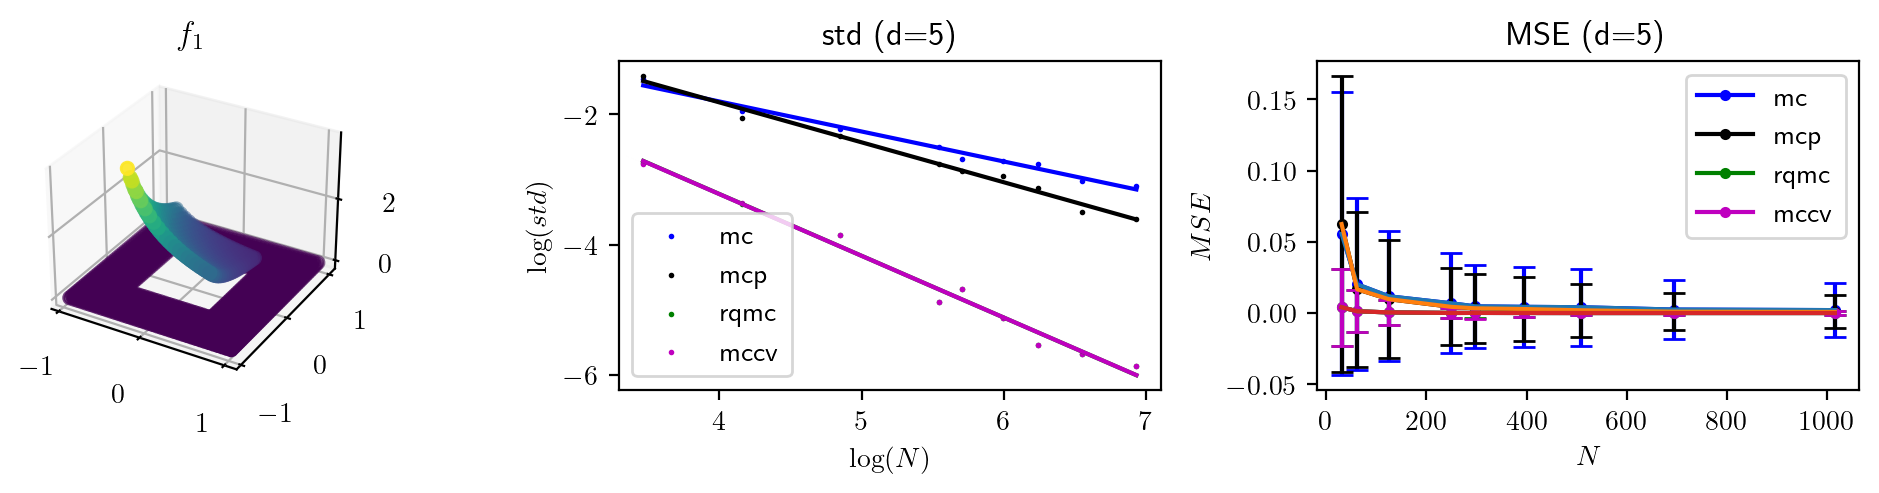

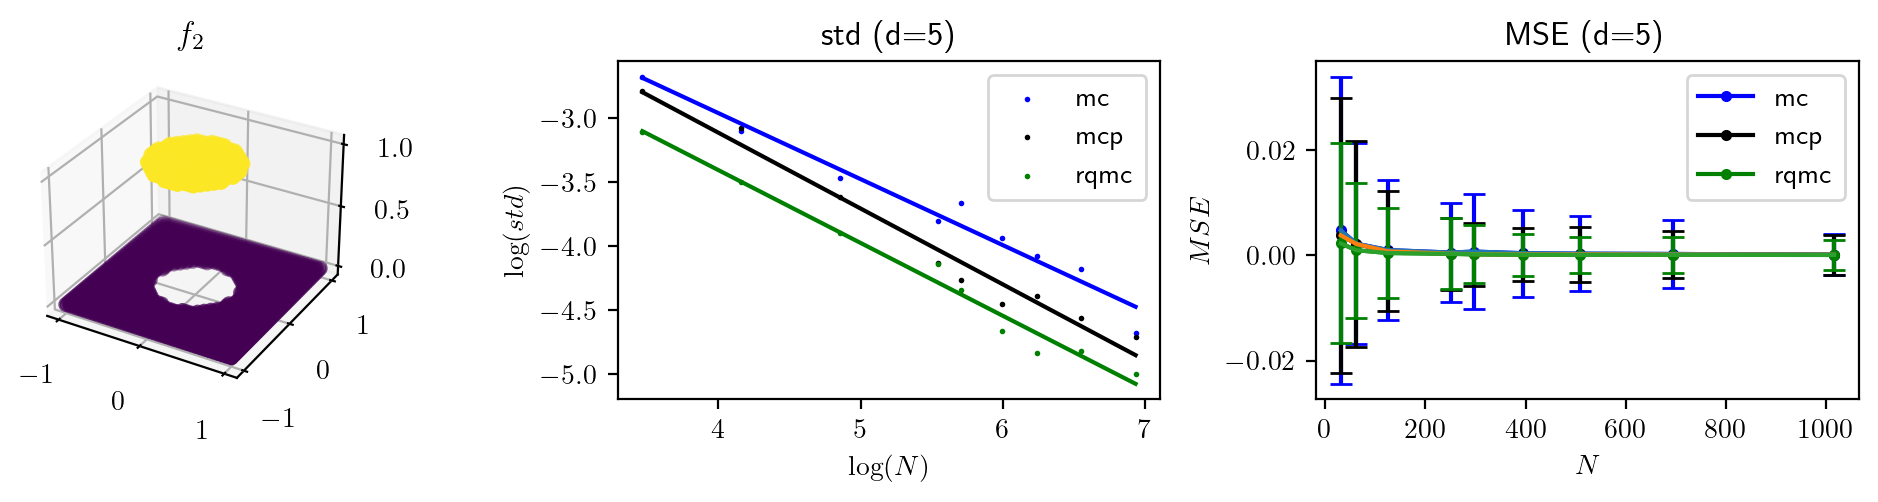

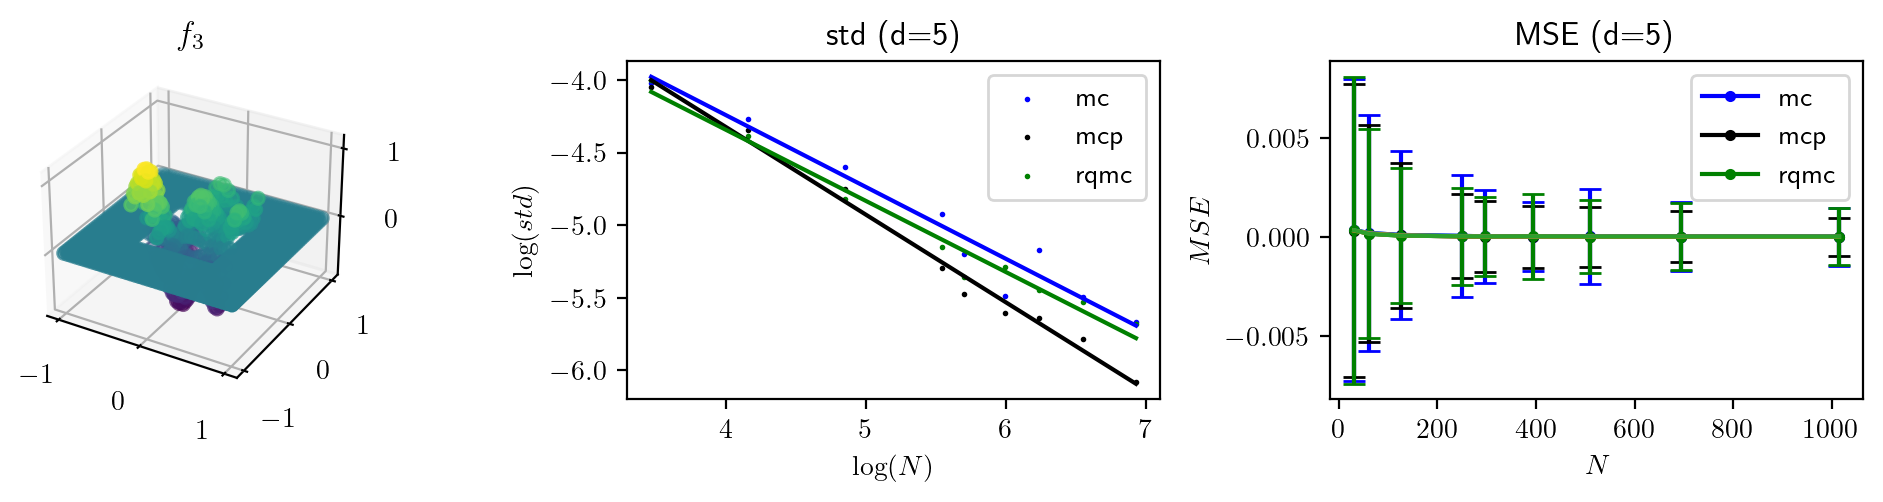

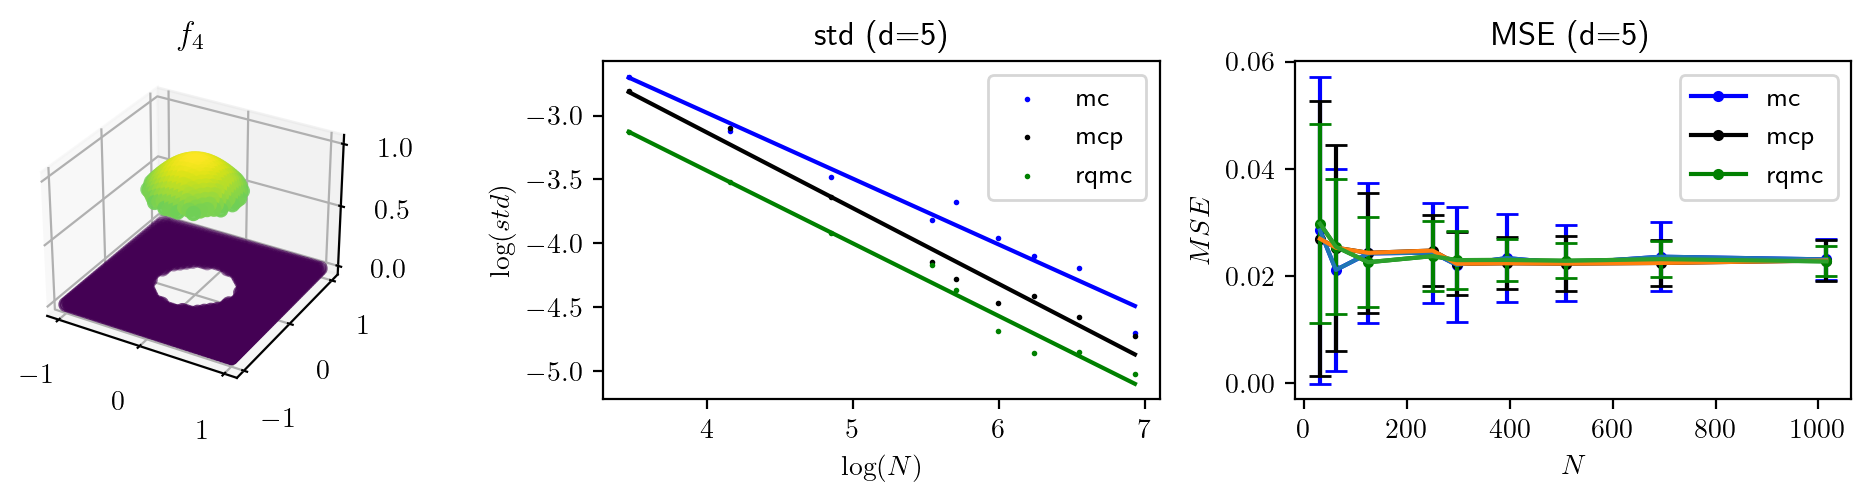

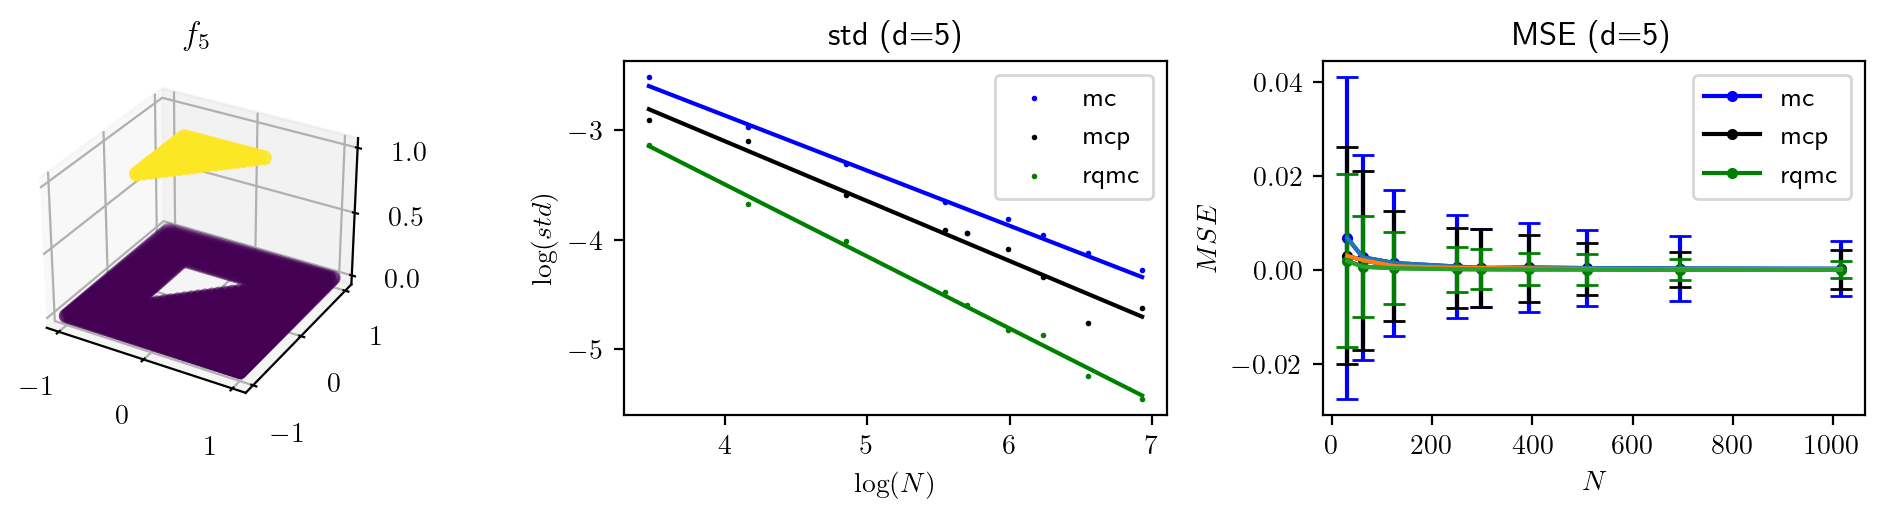

In [90]:
plot_mc_results(d, mc_results_5d, nb_point, nb_sample, save_fig=False)

In [91]:
d=6
#N = [2**5, 2**6, 2**7, 2**8, 300, 400,  2**9, 700, 2**(10), 1300, 1500, 2**(11)]
nb_point_list=[2**5, 2**6, 2**7, 2**8, 300, 400,  2**9, 700, 2**(10)]
nb_sample=50
nb_function=5
mc_results_5d, nb_point = mc_results(d, nb_point_list, nb_sample, nb_function)

d= 6 , nb points simu= [32, 64, 128, 256, 300, 400, 512, 700, 1024] , nb samples= 50
------------------------------------------------
N Big= 893 Nbig= 893 , N expected = 32 , Epsilon= 0.0005043833899974501
Time Push= 0 min 8.277400970458984 s
-----------------------------------------------
, N expected= 32 , N obtained 31
Time RQMC= 0 min 0.02315688133239746 s
For mc
---------------
FOR f1
error= [0.01258679] , std= [0.3035359567024513]
MSE= [0.0922925]
FOR f2
error= [-0.00010035] , std= [0.04973970770719563]
MSE= [0.00247405]
FOR f3
error= [-0.00089978] , std= [0.009557015918070025]
MSE= [9.21461526e-05]
FOR f4
error= [0.07931841] , std= [0.04938693017473912]
MSE= [0.00873048]
FOR f5
error= [0.00430108] , std= [0.06873932668284008]
MSE= [0.00474359]
For mcp
---------------
FOR f1
error= [-0.03186254] , std= [0.19930770865047662]
MSE= [0.04073878]
FOR f2
error= [-0.00366961] , std= [0.04926721399832787]
MSE= [0.00244072]
FOR f3
error= [-0.00056792] , std= [0.01067873268583696]
MSE= [0.

FOR f4
error= [0.07287913 0.07901525 0.07755393 0.07968006] , std= [0.04102649673763792, 0.03147303878480622, 0.019287494800794835, 0.011880707932594723]
MSE= [0.00699454 0.00723396 0.00638662 0.00649006]
FOR f5
error= [ 0.00172043  0.00579235  0.00444444 -0.00230159] , std= [0.04712643469785985, 0.024166076514312757, 0.016829002553541472, 0.008675136561127105]
MSE= [2.22386073e-03 6.17550569e-04 3.02968413e-04 8.05552985e-05]
For mccv
---------------
FOR f1
error= [ 0.00999522  0.002419   -0.00041677  0.00230694] , std= [0.08599277119761967, 0.05800960937627692, 0.017716037452993733, 0.012447006762650925]
MSE= [0.00749466 0.00337097 0.00031403 0.00016025]
Time MCCV= 0 min 0.006917238235473633 s
----------------------------------------------
----------------------------------------------
N Big= 8379 Nbig= 8379 , N expected = 300 , Epsilon= 5.375514587274412e-05
Time Push= 4 min 28.844640970230103 s
-----------------------------------------------
, N expected= 300 , N obtained 295
Time 

FOR f1
error= [ 0.00998033  0.00241724 -0.00041302  0.00230158  0.00246447 -0.00184288] , std= [0.08592324203666829, 0.05800661796295983, 0.017717335566834747, 0.012438724281465065, 0.016874239898604277, 0.009023019622670091]
MSE= [7.48241055e-03 3.37061077e-03 3.14074566e-04 1.60019125e-04
 2.90813582e-04 8.48111028e-05]
FOR f2
error= [-0.00655196 -0.00041764 -0.00185662  0.00028623 -0.0010167  -0.00144903] , std= [0.04134644802978424, 0.031810486433737996, 0.019467486661183253, 0.012001282404657351, 0.00947074861933725, 0.009054337415895225]
MSE= [1.75245699e-03 1.01208147e-03 3.82430087e-04 1.44112709e-04
 9.07287555e-05 8.40807133e-05]
FOR f3
error= [-0.00161893  0.00021486  0.00057688 -0.00059961  0.00110782  0.00029258] , std= [0.010533625279047481, 0.007571021718962608, 0.005405708175183291, 0.0031286467656059963, 0.00339723121003164, 0.002968910873923361]
MSE= [1.13578210e-04 5.73665339e-05 2.95544720e-05 1.01479623e-05
 1.27684354e-05 8.90003522e-06]
FOR f4
error= [0.07287913 

N Big= 19551 Nbig= 19551 , N expected = 700 , Epsilon= 2.3037919659747478e-05
Time Push= 12 min 20.031678199768066 s
-----------------------------------------------
, N expected= 700 , N obtained 695
Time RQMC= 0 min 0.023768901824951172 s
For mc
---------------
FOR f1
error= [ 0.01258679  0.00814166  0.02233879  0.02759903  0.02201633 -0.02840945
  0.00206608  0.003717  ] , std= [0.3035359567024513, 0.2475897776055735, 0.12016749478314885, 0.10590520412479312, 0.10621042650876399, 0.07069954666457906, 0.06988188381825089, 0.06891055269033923]
MSE= [0.0922925  0.06136698 0.01493925 0.01197762 0.01176537 0.00580552
 0.00488775 0.00476248]
FOR f2
error= [-0.00010035  0.0064676  -0.00741218  0.00028623  0.00054262 -0.00059476
 -0.00387423  0.00100988] , std= [0.04973970770719563, 0.037241688771680034, 0.02466136258380503, 0.0184234257704535, 0.01496501243904592, 0.014511468062981727, 0.011757216767080745, 0.009569399508970669]
MSE= [2.47404859e-03 1.42877327e-03 6.63123200e-04 3.39504547e

FOR f5
error= [ 0.00430108  0.00415301 -0.00190476  0.00261905 -0.00354802 -0.00435511
  0.00069967  0.00271463  0.00474777] , std= [0.06873932668284008, 0.046848944950500876, 0.037588411281214165, 0.023736660997997112, 0.018371837241108656, 0.01867855252154729, 0.01571601068603444, 0.013248130071058172, 0.012532611522088778]
MSE= [0.00474359 0.00221207 0.00141652 0.00057029 0.00035011 0.00036786
 0.00024748 0.00018288 0.00017961]
For mcp
---------------
FOR f1
error= [-0.03186254 -0.00789376 -0.01629913  0.00367201  0.00158287  0.00916052
  0.00044512 -0.00121906 -0.00655634] , std= [0.19930770865047662, 0.17926168935402825, 0.12909374414465838, 0.07581156533277328, 0.07130742801372625, 0.05895475159145765, 0.05092376411197935, 0.045034681259223434, 0.039221910935629184]
MSE= [0.04073878 0.03219706 0.01693086 0.00576088 0.00508725 0.00355958
 0.00259343 0.00202961 0.00158134]
FOR f2
error= [-0.00366961  0.00405998 -0.00066847 -0.00086505  0.0001717  -0.00076914
  0.00047758 -0.0007159

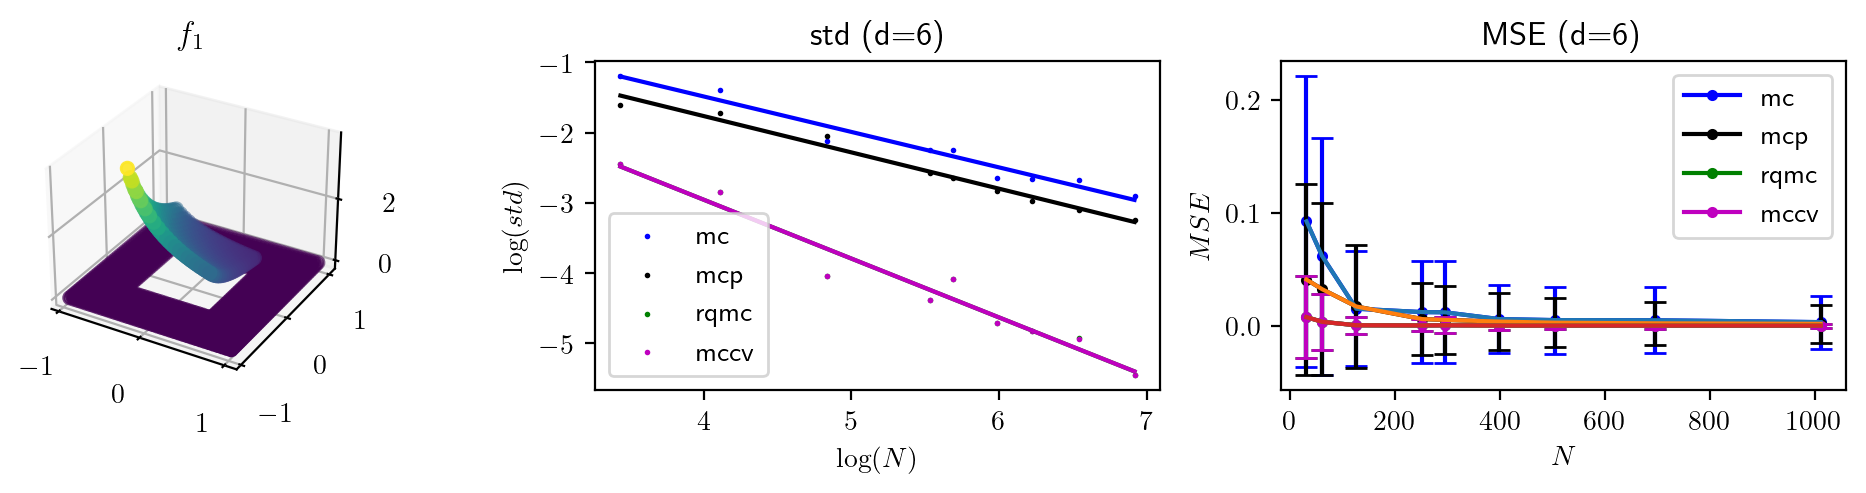

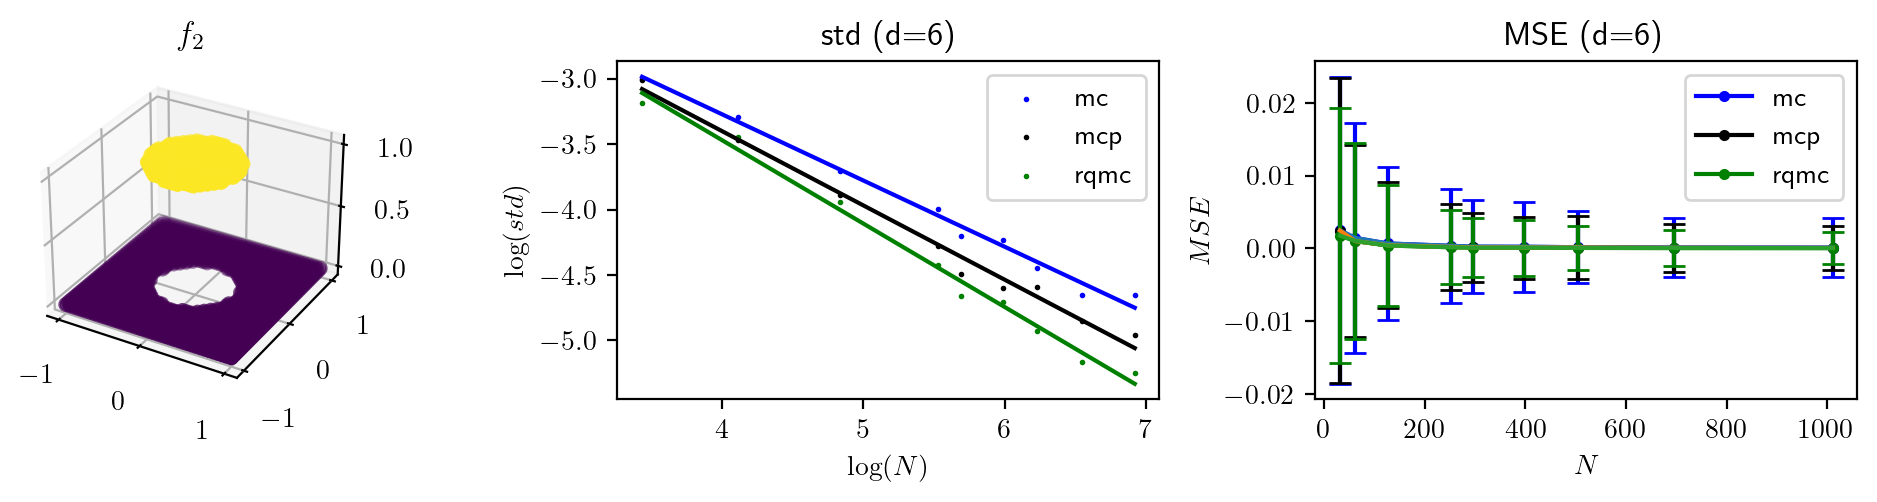

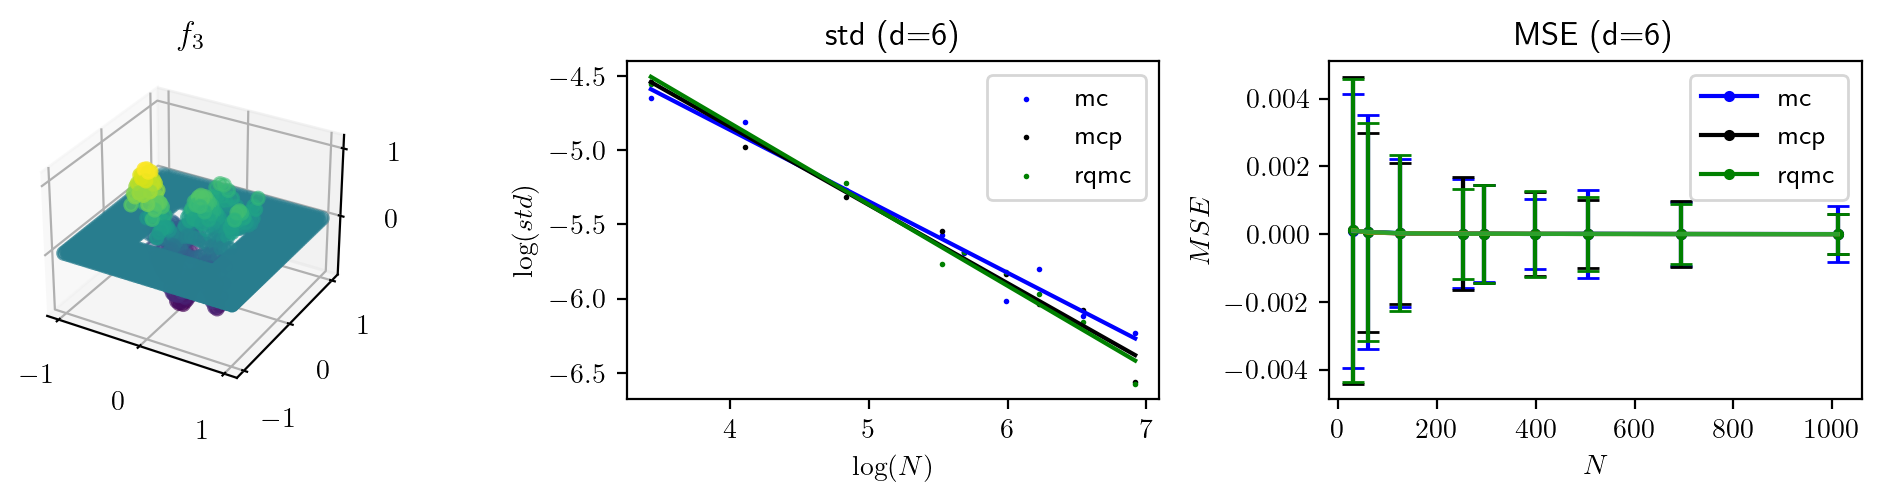

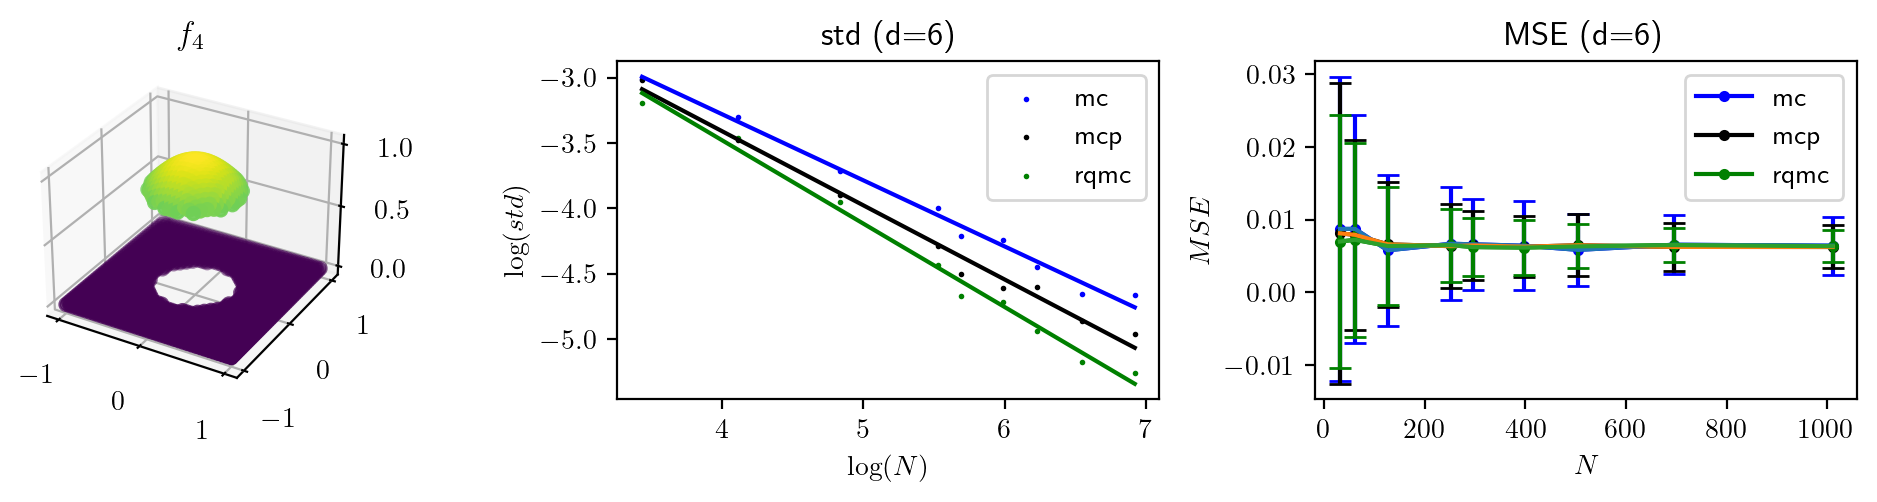

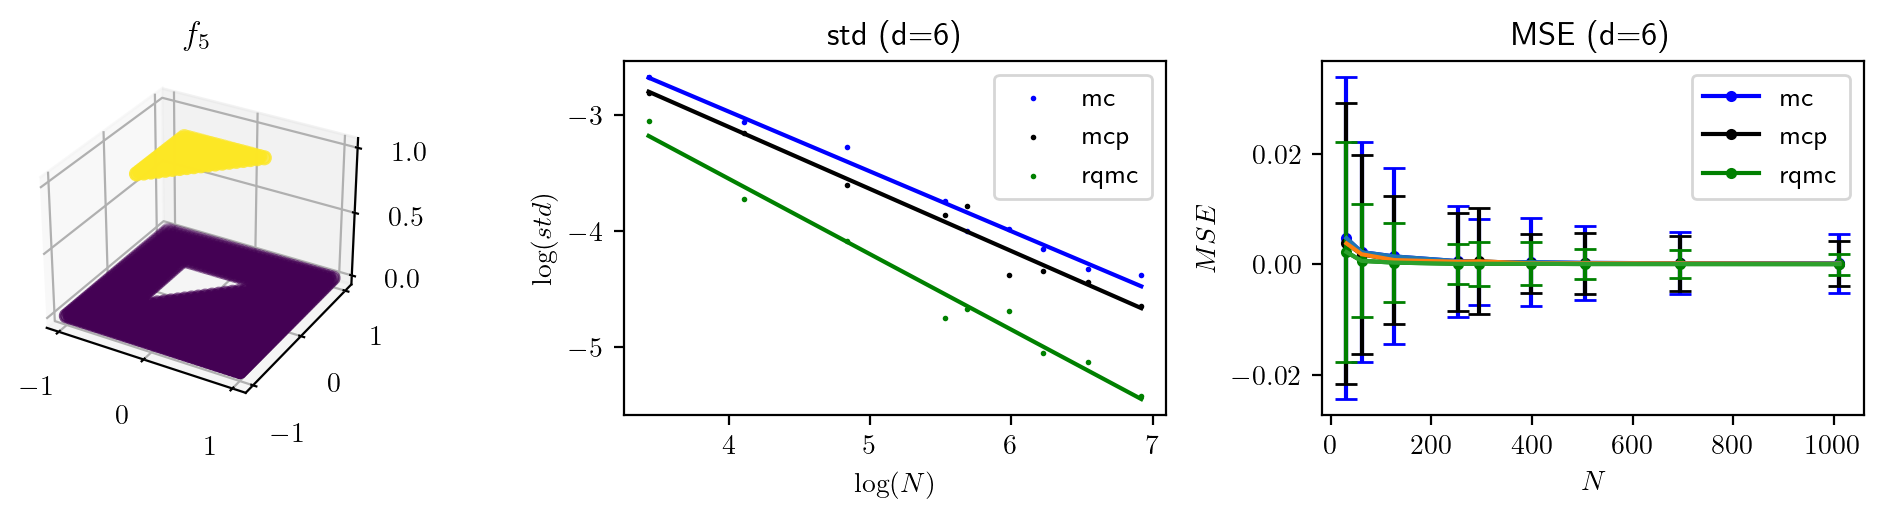

In [92]:
plot_mc_results(d, mc_results_5d, nb_point, nb_sample, save_fig=False)